In [ ]:
!pip install modisco
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from functools import partial
import ast
import dmslogo

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats

import Bio
from Bio import motifs
from operator import itemgetter
from modisco.visualization import viz_sequence

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

# from tqdm.auto import tqdm
# tqdm.pandas()
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

No GPU available


In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():   
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor
        
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq
    
    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT, 
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]   
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='Experimental', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = min(x_min, y_min), max(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        #title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        title = f'{title}  |  Pearson {Pearson}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)
        
        ax.tick_params(axis='both', which='major', labelsize=axis_font_size)

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

def ppm_to_IC_alt(in_tensor):
    U = (in_tensor.log2() * in_tensor).sum(dim=1).mul(-1.)
    return in_tensor * U[:, None, :].mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def consecutiveRanges(a):
    n = len(a)
    length = 1
    list = []    
    if (n == 0):
        return list    
    for i in range (1, n + 1):
        if (i == n or a[i] -
            a[i - 1] != 1):
            if (length == 1):
                list.append([a[i - length]])
            else:
                temp = [a[i - length], a[i - 1]]
                list.append(temp)
            length = 1        
        else:
            length += 1
    return list

In [ ]:
def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, num_motifs=None):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    if not num_motifs:
        Range = len(motif_dict)
    else:
        Range = num_motifs
    for motif_idx in range(Range):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()

### TF motifs

In [ ]:
# file_path = '/content/drive/MyDrive/data/tf_motifs/HOCOMOCOv11_truly_full_HUMAN_processed_TF_info.txt'

# tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)
# tf_df['database'] = 'HOCOMOCO'

# df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
# for df_array_column in tqdm(df_array_columns):
#     tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

# file_path = "/content/drive/MyDrive/data/tf_motifs/JASPAR2022_CORE_vertebrates_redundant_processed_TF_info_v0.txt"

# tf_df_2 = pd.read_csv(file_path, sep=' ', low_memory=False)
# tf_df_2['database'] = 'JASPAR'

# for df_array_column in tqdm(df_array_columns):
#     tf_df_2[df_array_column] = tf_df_2.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

# tf_df = pd.concat([tf_df, tf_df_2]).reset_index(drop=True)

# tf_max_length = tf_df.length.max()
# padding_fn = partial(utils.pad_pssm, column_name='pssm', pad_len=tf_max_length)
# rc_padding_fn = partial(utils.pad_pssm, column_name='pssm_rc', pad_len=tf_max_length)
# tf_df['padded_pssm'] = tf_df.apply(padding_fn, axis=1)
# tf_df['padded_pssm_rc'] = tf_df.apply(rc_padding_fn, axis=1)

# # tf_df.to_csv("/content/drive/MyDrive/data/tf_motifs/HOCOMOCO_and_JASPAR_processed_TF_info.txt", index=None, sep=' ')

In [ ]:
file_path = '/content/drive/MyDrive/data/tf_motifs/HOCOMOCO_and_JASPAR_processed_TF_info.txt'

tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)
tf_df['database'] = 'HOCOMOCO'

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

### Sequence library

In [ ]:
#----- BODA sequences -------
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)

In [ ]:
target_cell = 'k562' #k562, hepg2, sknsh
method_subset = ['fsp'] #['fsp', 'al', 'sa']

quality_filter = (no_controls_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
data_df = no_controls_df[quality_filter].copy().reset_index(drop=True)

data_df = data_df[data_df['method'].isin(method_subset)].reset_index(drop=True)
data_df = data_df[data_df['target_cell'] == target_cell].reset_index(drop=True)

In [ ]:
row_filter = (data_df['method'] == 'fsp') #& (data_df['round'] > 0)
# track_info = [a[0] + '__' + a[1] if len(a[0])==15 else a[0].split('_')[0] + '_0' + a[0].split('_')[1] + '__' + a[1] \
#               for a in data_df[row_filter]['ID'].str.split('__').tolist() ]
track_info = [a[1] for a in data_df[row_filter]['ID'].str.split('__').tolist() ]
data_df.loc[row_filter, 'penalty_track'] = track_info

In [ ]:
data_df['penalty_track'].dropna().unique()

array(['323391', '477844', '730114', '619474', '893131'], dtype=object)

In [ ]:
streme_dicts = {}
for root, dirs, files in os.walk('/content/drive/MyDrive/data/BODA2_MPRA/fsp_streme_dicts'):
    for file_path in files:
        if target_cell in file_path:
            _, method, cell_type, track_ID, random_tag, round = file_path.split('__')
            if round != 'round_0':
                #track_info = ('__').join([track_ID, random_tag, round.rstrip('.pt')])
                track_info = random_tag + '__' + round.rstrip('.pt')
                print(file_path)
                streme_dicts[track_info] = torch.load(root + '/' + file_path)

streme_penalty__fsp__k562__20211212_092818__893131__round_5.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_2.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_1.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_3.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_4.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_4.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_4.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_1.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_1.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_2.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_3.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_1.pt
streme_penalty__fsp__k562__20211212_022207__477844__rou

Track 619474

round 1


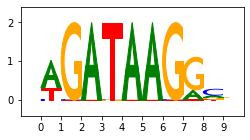

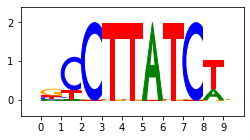


round 2


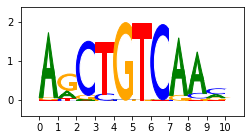

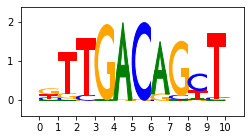


round 3


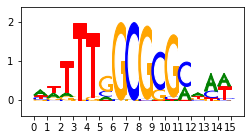

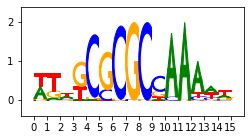


round 4


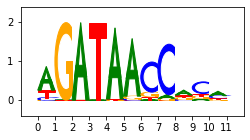

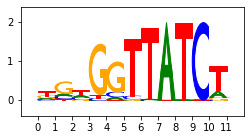


round 5


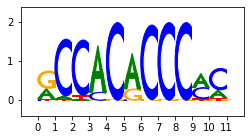

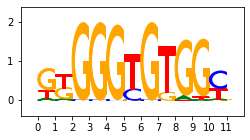



Track 893131

round 1


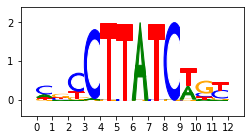

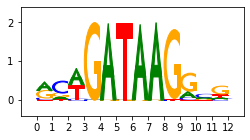


round 2


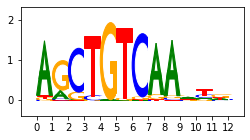

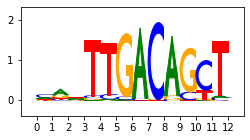


round 3


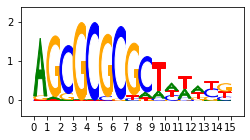

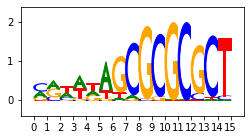


round 4


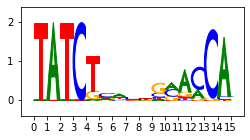

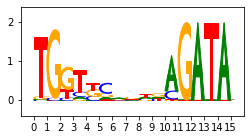


round 5


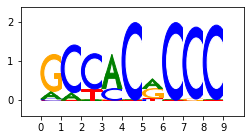

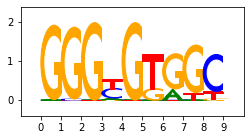



Track 477844

round 1


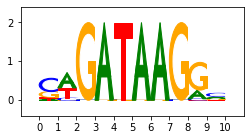

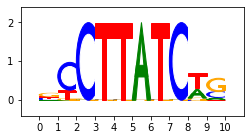


round 2


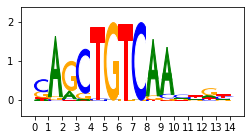

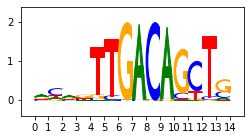


round 3


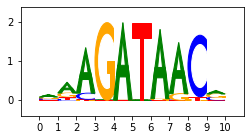

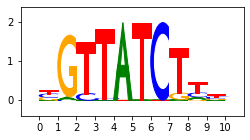


round 4


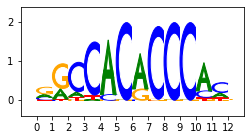

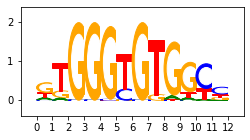


round 5


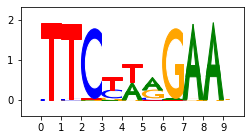

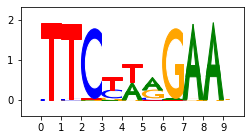



Track 730114

round 1


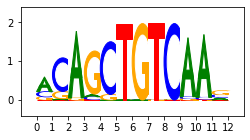

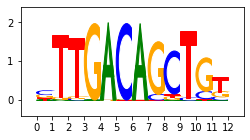


round 2


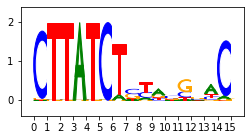

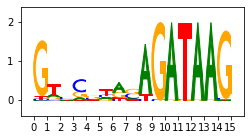


round 3


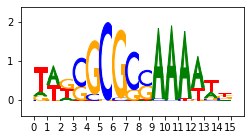

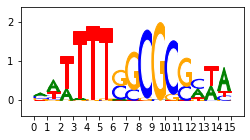


round 4


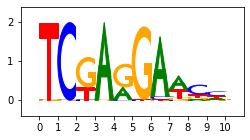

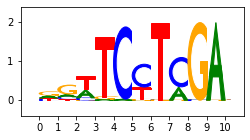


round 5


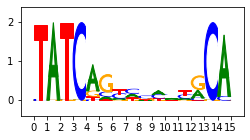

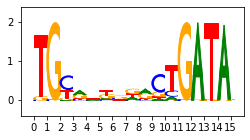

In [ ]:
penalty_tracks = list(set([a.split('__')[0] for a in streme_dicts.keys()]))

for penalty_track in penalty_tracks:
    print(f'Track {penalty_track}')
    temp_df = data_df[data_df['penalty_track'] == penalty_track].reset_index(drop=True)
    # plt.figure(figsize=(8,5))
    # sns.violinplot(data=temp_df, x='round', y='OverMax')
    # plt.ylabel('OverMax')
    # plt.show()
    print('')

    onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in temp_df['sequence'].tolist()]).type(torch.float32)
    for Round in range(1,6):
        print(f'round {Round}')
        stremed_batch_df = temp_df[temp_df['round'] == Round-1]
        track_key = penalty_track + '__round_' + str(Round)
        penalized_ppm = torch.tensor(streme_dicts[track_key]['motif_results'][0]['ppm'])
        penalized_ppm_rc = reverse_complement(penalized_ppm)
        penalized_pwm = ppm_to_pwm(penalized_ppm)
        penalized_pwm_rc = ppm_to_pwm(penalized_ppm_rc)
        penalized_icm = ppm_to_IC(penalized_ppm)
        penalized_icm_rc = ppm_to_IC(penalized_ppm_rc)

        viz_sequence.plot_weights(penalized_icm.T.numpy(), figsize=(penalized_icm.shape[0],2))
        viz_sequence.plot_weights(penalized_icm_rc.T.numpy(), figsize=(penalized_icm_rc.shape[0],2))

        filters = torch.stack([penalized_pwm, penalized_pwm_rc]).type(torch.float32)

        temp_scores = F.conv1d(onehot_sequences, filters)
        temp_max_scores = torch.max(temp_scores, dim=-1)[0].max(dim=-1)[0]

        temp_df['temp_max_score'] = temp_max_scores.numpy()

        # plt.figure(figsize=(8,5))
        # sns.violinplot(data=temp_df, x='round', y='temp_max_score')
        # plt.ylabel('max motif score')
        # plt.show()
        print('')
    print('')

### Known-motif matching

In [ ]:
motif_list = tf_df['name'].tolist()

PSSMs = torch.Tensor(np.stack(tf_df['padded_pssm'].tolist(), axis=0))
PSSMs_rc = torch.Tensor(np.stack(tf_df['padded_pssm_rc'].tolist(), axis=0))
filters = torch.cat([PSSMs, PSSMs_rc])

threshold_scores = torch.Tensor(np.stack(tf_df['threshold_patser'].tolist(), axis=0))
threshold_scores = torch.cat([threshold_scores, threshold_scores])

pad_len = filters.shape[-1]

In [ ]:
penalty_tracks

['619474', '893131', '477844', '730114']

In [ ]:
penalty_track = '893131' 

# k562: '893131', '477844', '619474', '730114'
# hepg2: '944763', '313665', '969454', '346635'
# sknsh: '817810', '621411', '958155', '199840'

penalized_ppms = []
penalized_ppms_rc = []
penalized_pwms = []
penalized_pwms_rc =[]
penalized_icms = []
penalized_icms_rc = []
for Round in range(1,6):
    track_key = penalty_track + '__round_' + str(Round)
    penalized_ppm = torch.tensor(streme_dicts[track_key]['motif_results'][0]['ppm'])
    penalized_ppm_rc = reverse_complement(penalized_ppm)
    penalized_pwm = ppm_to_pwm(penalized_ppm)
    penalized_pwm_rc = ppm_to_pwm(penalized_ppm_rc)
    penalized_icm = ppm_to_IC(penalized_ppm)
    penalized_icm_rc = ppm_to_IC(penalized_ppm_rc)

    penalized_ppms.append(penalized_ppm)
    penalized_ppms_rc.append(penalized_ppm_rc)
    penalized_pwms.append(penalized_pwm)
    penalized_pwms_rc.append(penalized_pwm_rc)
    penalized_icms.append(penalized_icm)
    penalized_icms_rc.append(penalized_icm_rc)

In [ ]:
# to_print_motif = penalized_ppms[4]
# for column in range(to_print_motif.shape[-1]):
#     to_print_row = [np.round(x, 6) for x in to_print_motif[:, column].tolist()]
#     print(f'{to_print_row[0]} {to_print_row[1]} {to_print_row[2]} {to_print_row[3]} ')

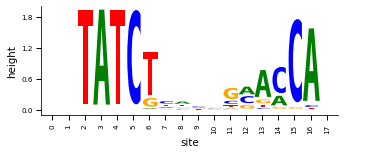

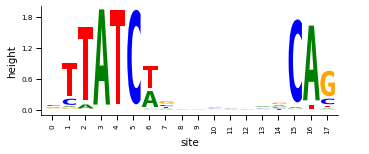

GATA1::TAL1 (MA0140.2)
0.79



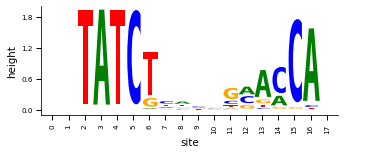

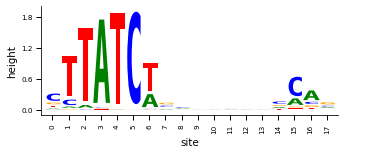

Gata1::Tal1 (MA0140.1)
0.77



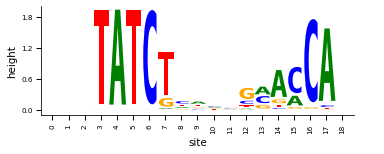

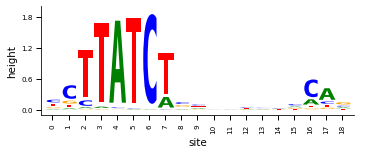

GATA2 (GATA2_HUMAN.H11MO.0.A)
0.75



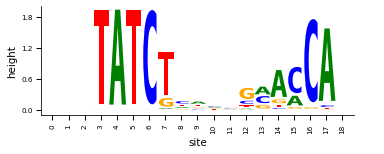

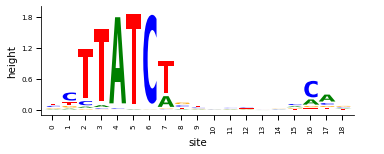

GATA1 (GATA1_HUMAN.H11MO.0.A)
0.74



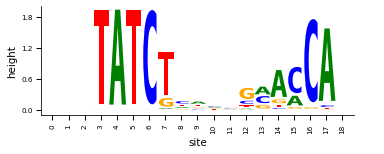

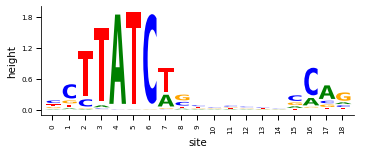

TAL1 (TAL1_HUMAN.H11MO.0.A)
0.73



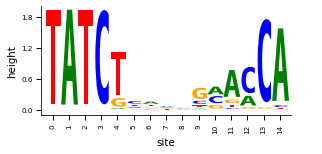

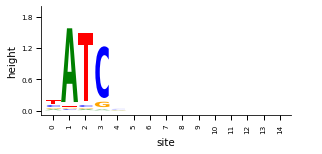

GATA2 (MA0036.1)
0.56



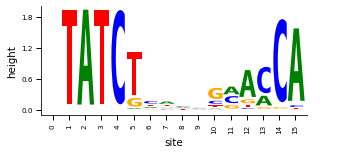

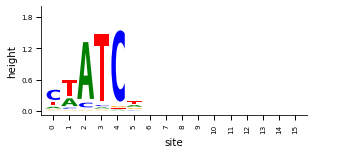

GATA3 (MA0037.1)
0.53



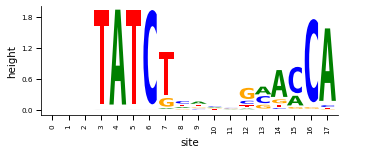

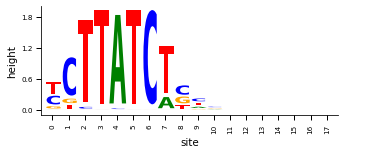

Gata4 (MA0482.1)
0.51



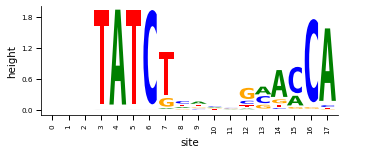

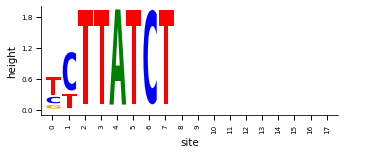

GATA3 (MA0037.2)
0.5



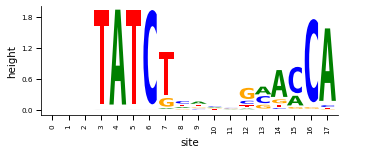

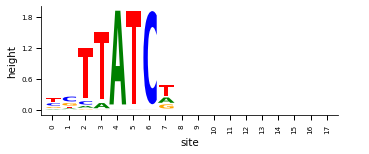

GATA3 (MA0037.3)
0.49



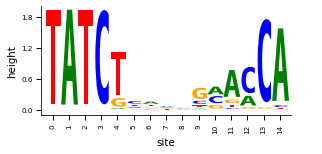

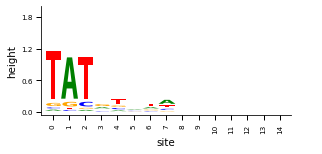

FOXL1 (MA0033.1)
0.48



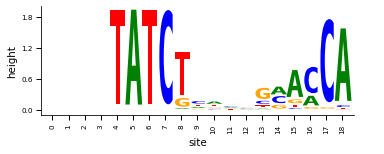

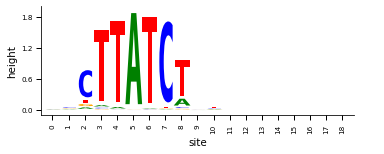

GATA2 (MA0036.3)
0.48



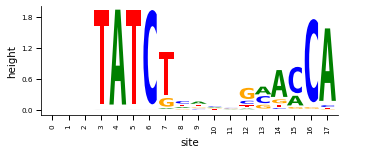

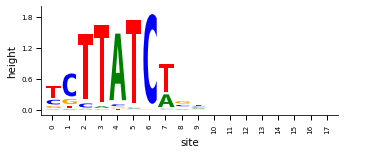

GATA4 (GATA4_HUMAN.H11MO.0.A)
0.48



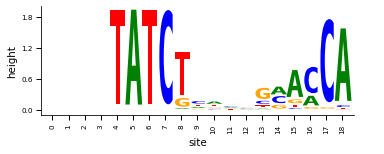

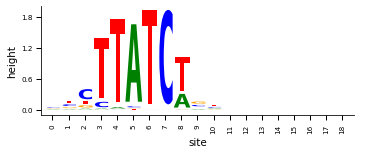

Gata1 (MA0035.2)
0.48



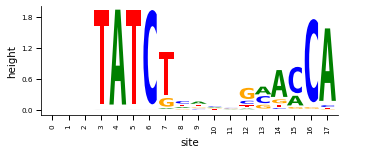

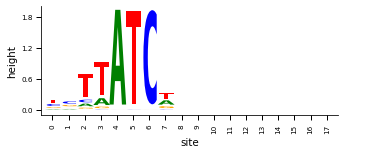

GATA5 (MA0766.1)
0.48



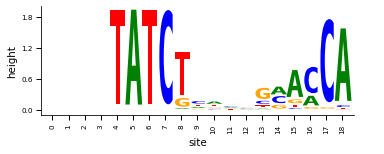

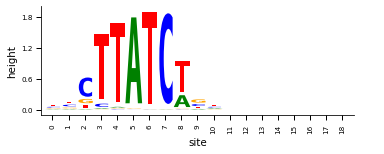

GATA1 (GATA1_HUMAN.H11MO.1.A)
0.47



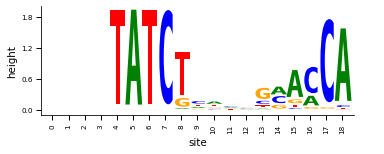

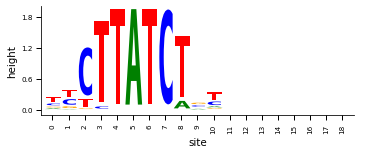

Gata1 (MA0035.3)
0.47



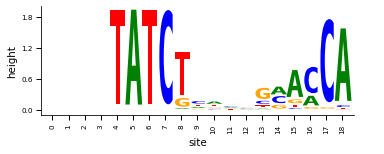

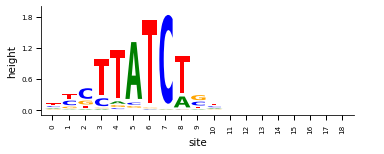

GATA2 (GATA2_HUMAN.H11MO.1.A)
0.47



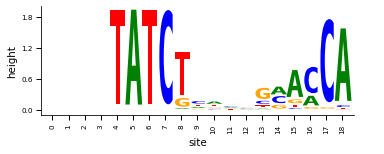

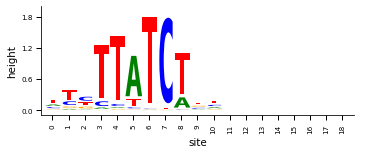

GATA3 (GATA3_HUMAN.H11MO.0.A)
0.47



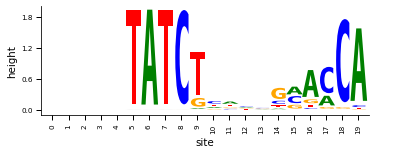

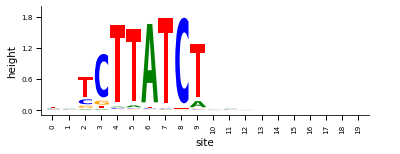

GATA6 (MA1104.1)
0.46



In [ ]:
#icm_colum = {False: 'icm', True:'icm_rc'}
icm_colum = {False: 'pwm', True:'pwm_rc'}
#icm_colum = {False: 'pwm', True:'pwm_rc'}
criterion = 'True_Pearson'  # Inside_KL_div Outside_KL_div Inside_Pearson Outside_Pearson True_Pearson True_KL_div

top_n = 100

selected_match_icms = []
selected_match_idxs = []
selected_match_names = []
selected_rc_flags = []
selected_match_shifts = []
selected_criterion_values = []
for group_idx, found_tf in enumerate(penalized_ppms):
    padded_found_tf = double_pad_seq_tensor(found_tf, pad_len=pad_len)

    x = F.conv1d(padded_found_tf.view(1,4,-1), filters)
    x = x.flatten(0,1)

    values, indices = x.max(dim=-1)
    #values[values < threshold_scores] = np.nan
    values, indices = values.numpy().flatten(), indices.numpy().flatten()

    ordering = np.argsort(-values)
    positions = indices[ordering]
    rc_flags = (ordering // len(tf_df)).astype(bool)
    motif_idxs = ordering % len(tf_df)

    window_start = pad_len - 1
    window_stop =  padded_found_tf.shape[-1] - window_start
    array_1 = padded_found_tf[:, window_start:window_stop]

    in_kl_divs = []
    in_pearsons = []
    out_kl_divs = []
    out_pearsons = []
    true_pearsons = []
    true_kl_divs = []
    match_shifts = []
    trimming_windows = []
    for i in range(top_n):
        motif_idx = motif_idxs[i]
        motif_pos = positions[i]
        rc_flag = rc_flags[i]

        match = torch.tensor(tf_df.iloc[motif_idx][icm_colum[rc_flag]])
        shift_match = torch.zeros(padded_found_tf.shape)
        shift_match[..., motif_pos:motif_pos + match.shape[-1]] = match

        array_2 = shift_match[:, window_start:window_stop]

        in_kl_divs.append(F.kl_div(array_1, array_2, reduction='batchmean', log_target=False).item())
        in_pearsons.append(np.corrcoef(array_1.numpy().flatten(), array_2.numpy().flatten())[0, 1])

        array_alt_1 = padded_found_tf[:, motif_pos:motif_pos + match.shape[-1]]
        array_alt_2 = shift_match[:, motif_pos:motif_pos + match.shape[-1]]

        out_kl_divs.append(F.kl_div(array_alt_1, array_alt_2, reduction='batchmean', log_target=False).item())
        out_pearsons.append(np.corrcoef(array_alt_1.numpy().flatten(), array_alt_2.numpy().flatten())[0, 1])

        window_min_start = min(window_start, motif_pos)
        window_max_stop = max(window_stop, motif_pos + match.shape[-1])
        array_alt_alt_1 = padded_found_tf[:, window_min_start:window_max_stop]
        array_alt_alt_2 = shift_match[:, window_min_start:window_max_stop]

        true_kl_divs.append(F.kl_div(array_alt_alt_1, array_alt_alt_2, reduction='batchmean', log_target=False).item())
        true_pearsons.append(np.corrcoef(array_alt_alt_1.numpy().flatten(), array_alt_alt_2.numpy().flatten())[0, 1])

        match_shifts.append(motif_pos - window_start)
        trimming_windows.append([min(motif_pos, window_start), max(window_stop, motif_pos + match.shape[-1])])

    in_kl_divs = np.array(in_kl_divs)
    in_pearsons = np.array(in_pearsons)
    out_kl_divs = np.array(out_kl_divs)
    out_pearsons = np.array(out_pearsons)
    true_pearsons = np.array(true_pearsons)
    true_kl_divs = np.array(true_kl_divs)

    criterion_dict = {'Inside_KL_div': -in_kl_divs,
                      'Outside_KL_div': -out_kl_divs,
                      'Inside_Pearson': in_pearsons,
                      'Outside_Pearson': out_pearsons,
                      'True_Pearson': true_pearsons,
                      'True_KL_div': -true_kl_divs
                      }
    criterion_array = criterion_dict[criterion]
    if group_idx == 3:
        for idx in np.argsort(-criterion_array)[:20]:
            #idx = np.argsort(-criterion_array)[0]
            criterion_value = np.round(criterion_array[idx], 2)

            motif_idx = motif_idxs[idx]
            motif_pos = positions[idx]
            rc_flag = rc_flags[idx]
            match_shift = match_shifts[idx]
            trimming_window = trimming_windows[idx]
            match_motif_name = tf_df.iloc[motif_idx]['short_name'] + ' (' + tf_df.iloc[motif_idx]['name'] + ')'
            
            plot_matrix = padded_found_tf[:, trimming_window[0]:trimming_window[1]]
            plot_matrix = torch.nan_to_num(ppm_to_IC(plot_matrix))
            matrix_to_dms(plot_matrix)
            plt.show()

            best_match = torch.tensor(tf_df.iloc[motif_idx][icm_colum[rc_flag]])
            shift_best_match = torch.zeros(padded_found_tf.shape)
            shift_best_match[..., motif_pos:motif_pos + best_match.shape[-1]] = best_match

            plot_matrix = shift_best_match[:, trimming_window[0]:trimming_window[1]]
            plot_matrix = torch.nan_to_num(ppm_to_IC(plot_matrix))
            matrix_to_dms(plot_matrix)
            plt.show()

            selected_match_icms.append(best_match)
            selected_match_idxs.append(motif_idx)
            selected_match_names.append(match_motif_name)
            selected_rc_flags.append(rc_flag)
            selected_match_shifts.append(match_shift)
            selected_criterion_values.append(criterion_value)

            print(match_motif_name)
            print(np.round(criterion_array[idx], 2))
            print('')

In [ ]:
# match_motif_ids = ['HIC2_HUMAN.H11MO.0.D',
#                    'MA1130.1',
#                    'TF65_HUMAN.H11MO.0.A',
#                    'MA1420.1',
#                    'MA0794.1'               
#                   ]
# selected_match_idxs = [tf_df[tf_df['name'] == motif_id].index.item() for motif_id in match_motif_ids]

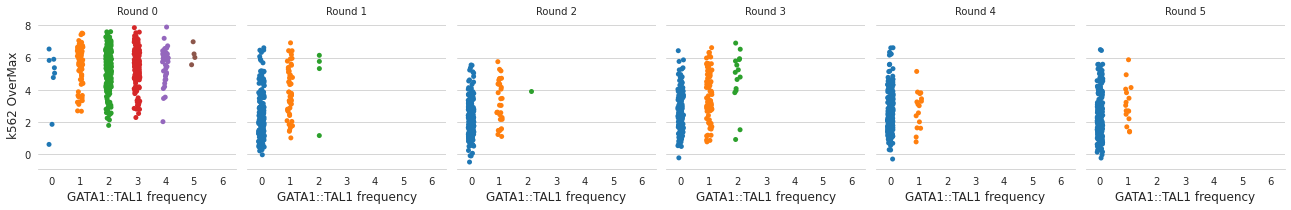

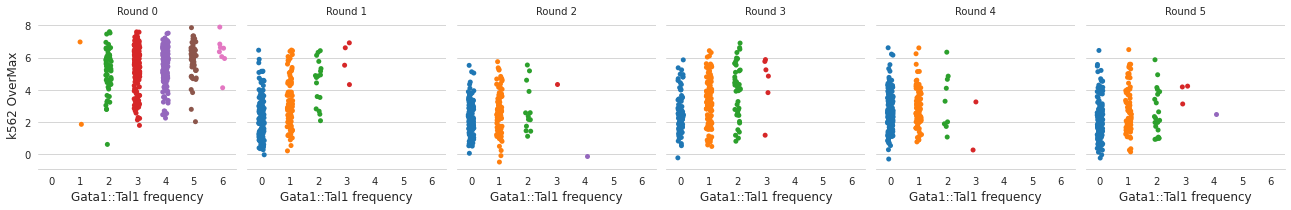

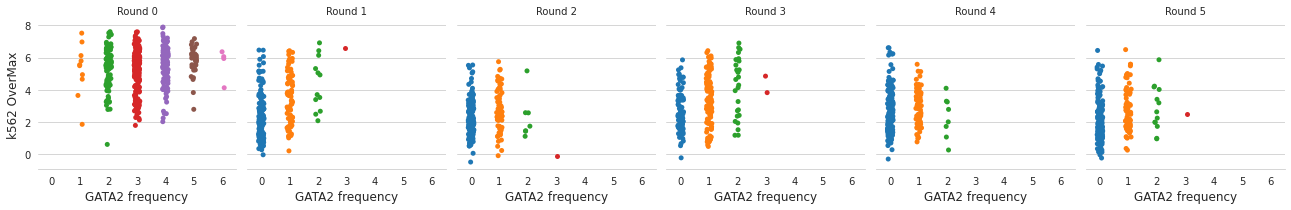

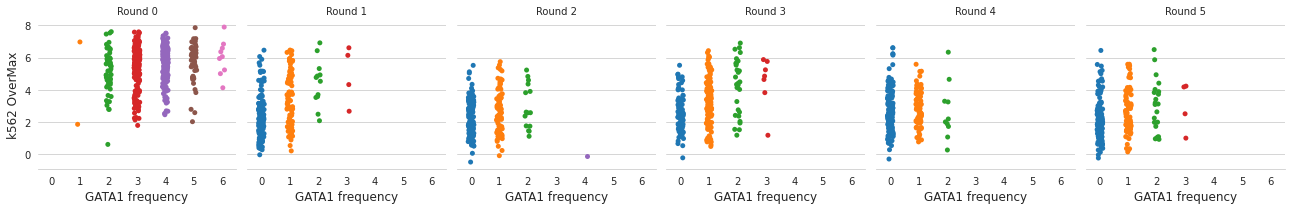

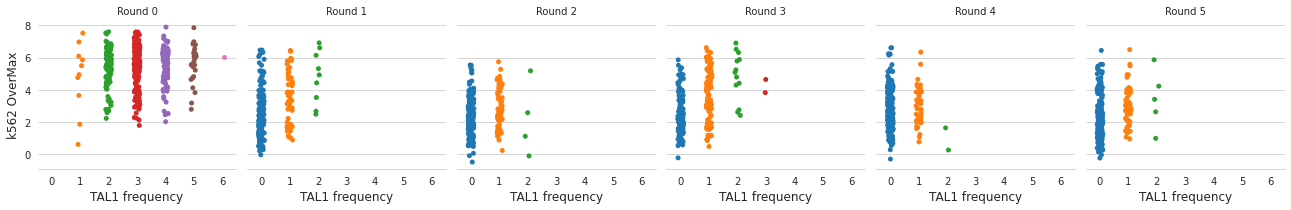

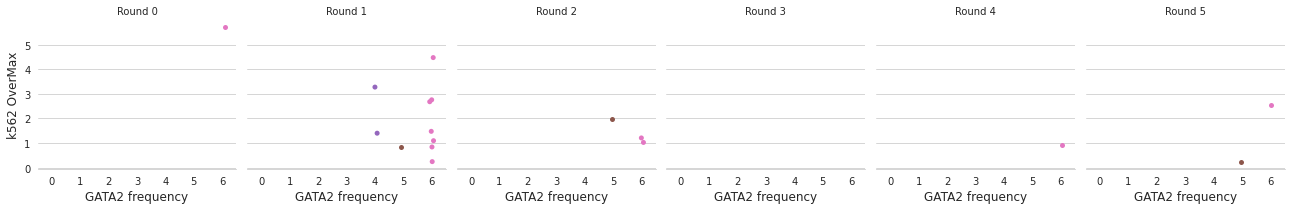

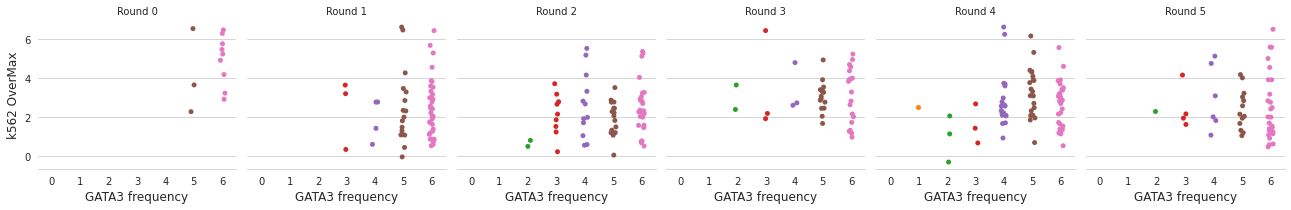

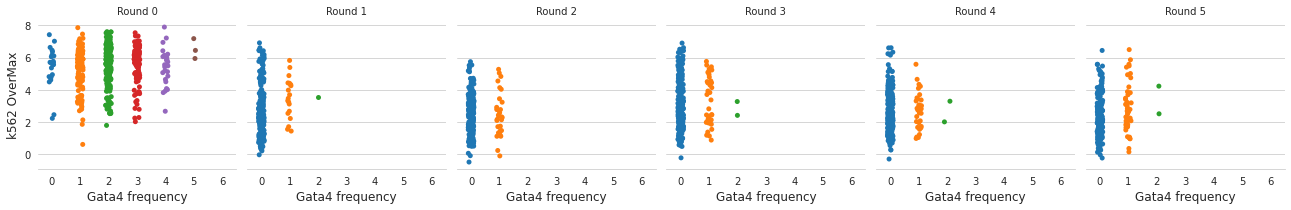

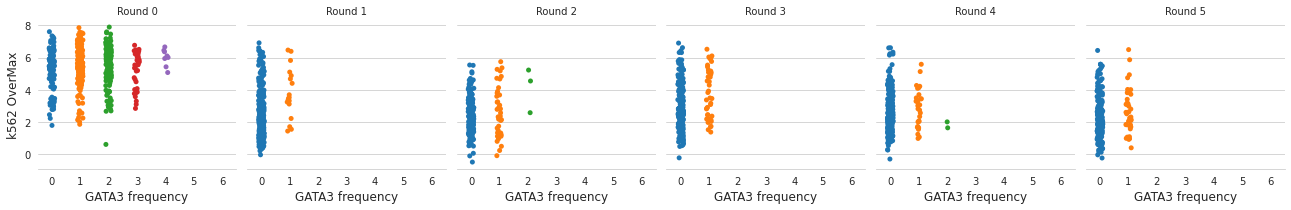

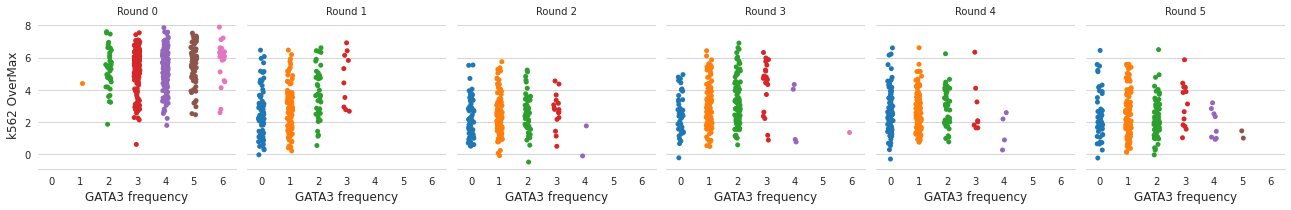

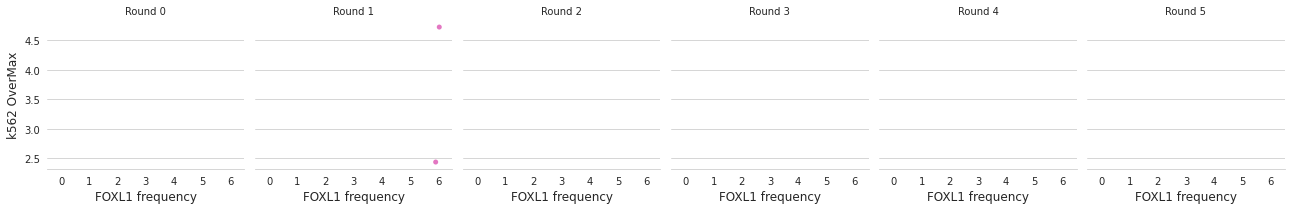

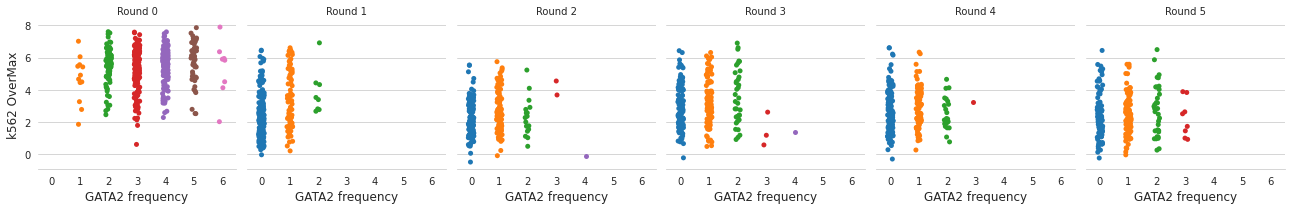

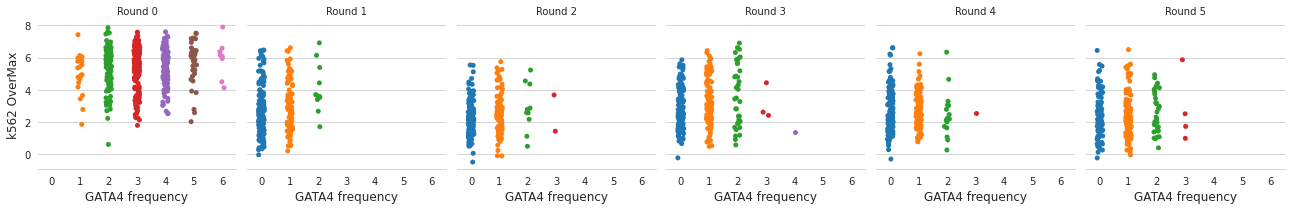

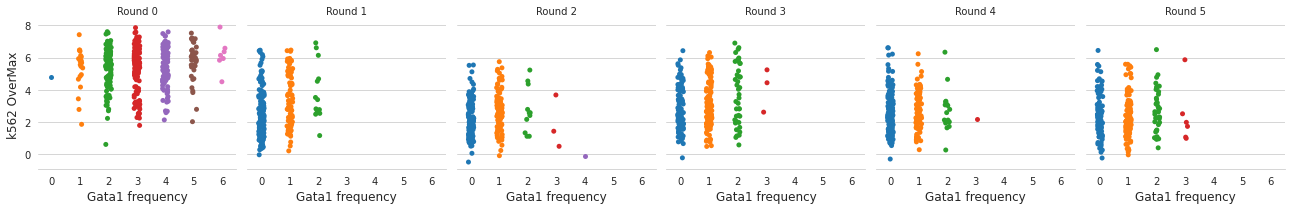

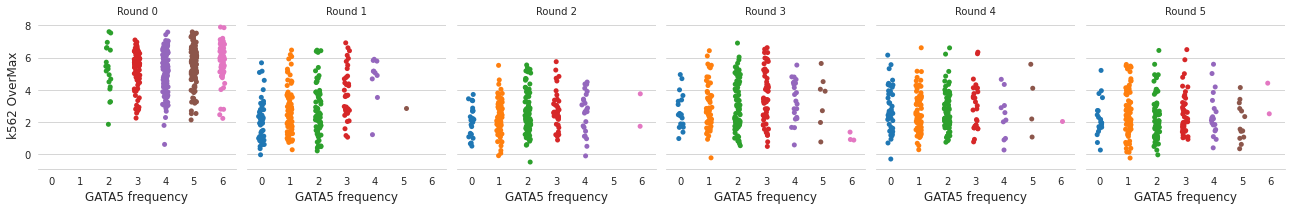

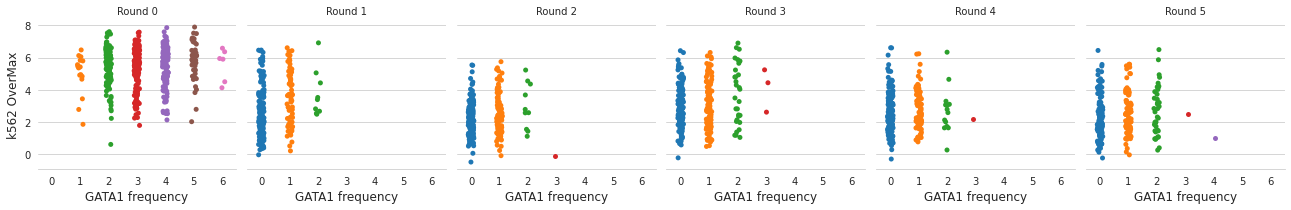

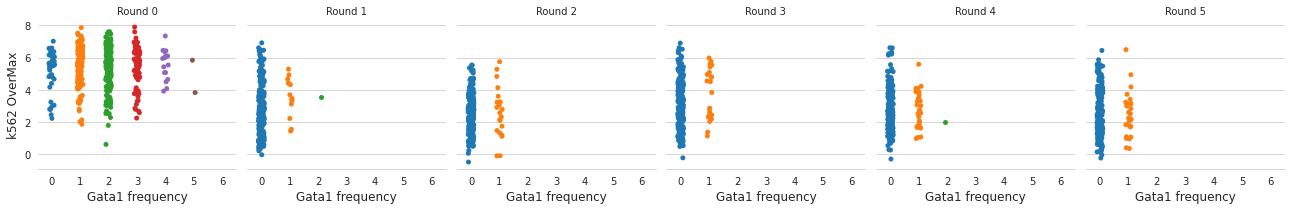

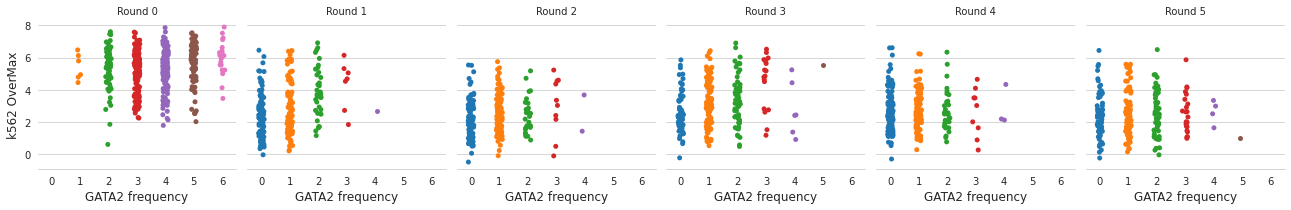

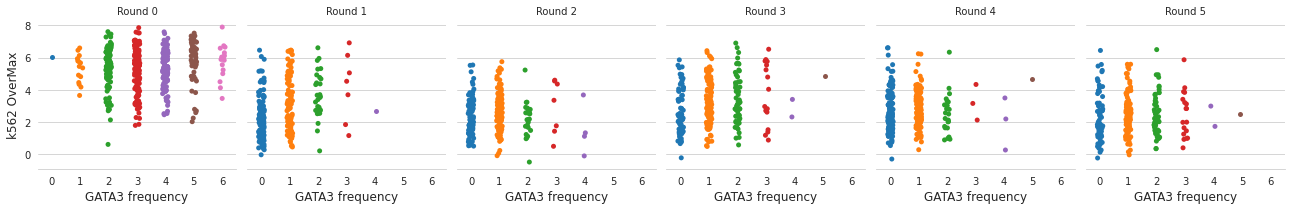

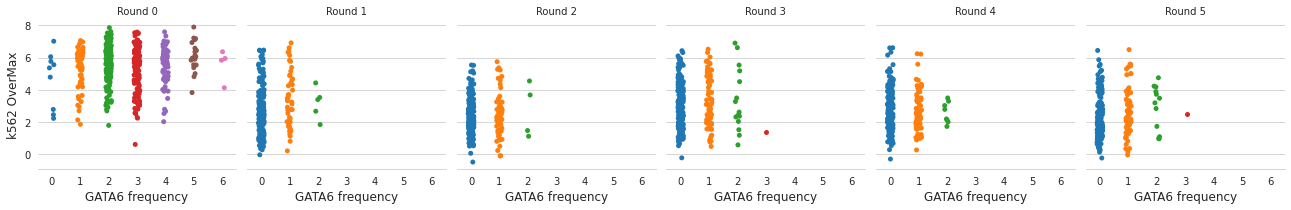

In [ ]:
for match_motif_idx in selected_match_idxs:
    motif_name = tf_df.iloc[match_motif_idx]['short_name']
    temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

    score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
    max_score = tf_df.iloc[match_motif_idx]['max_score']

    track_df = data_df[(data_df['penalty_track'] == penalty_track)].reset_index()
    track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                              for seq in track_df['sequence'].tolist()]).type(torch.float32)
    track_scores = F.conv1d(track_onehot_sequences, temp_filters)
    motif_frequencies = (track_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
    track_df['motif_frequency'] = list(motif_frequencies)
    
    with sns.axes_style("whitegrid"):
        g = sns.catplot(data=track_df, x='motif_frequency', y='OverMax', col='round', kind='strip',
                    order=list(range(7)), height=3, aspect=1)#, s=1.)
        x_label = f'{motif_name} frequency'
        g.set_axis_labels(x_label, f"{target_cell} OverMax", fontsize=12)
        #g.set_xticklabels(["Men", "Women", "Children"])
        g.set_titles("Round {col_name}")
        #g.set(ylim=(0, 1))
        g.despine(left=True)
        plt.show()

In [ ]:
track_df = data_df[(data_df['penalty_track'] == penalty_track)].reset_index()
for match_motif_idx in selected_match_idxs:
    motif_name = tf_df.iloc[match_motif_idx]['short_name']
    temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

    score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
    #max_score = tf_df.iloc[match_motif_idx]['max_score']

    track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                              for seq in track_df['sequence'].tolist()]).type(torch.float32)
    track_scores = F.conv1d(track_onehot_sequences, temp_filters)
    motif_frequencies = (track_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
    track_df[f'{motif_name}_frequency'] = list(motif_frequencies)

motif_columns = track_df.columns[-5:].tolist()

string_vectors = [str(track_df[motif_columns].to_numpy()[row, :]) for row in range(len(track_df))]
track_df['motif_vector'] = string_vectors
uniques, counts = np.unique(string_vectors, return_counts=True)
all_x_ticks = uniques.tolist()
all_counts = counts.tolist()

len(all_x_ticks)

892

In [ ]:
all_motif_boxes = []
for i in range(5):
    motif_boxes = [all_x_ticks.index(tick) for tick in all_x_ticks if tick.lstrip('[').rstrip(']').split(' ')[i] != '0']
    all_motif_boxes.append(consecutiveRanges(motif_boxes))

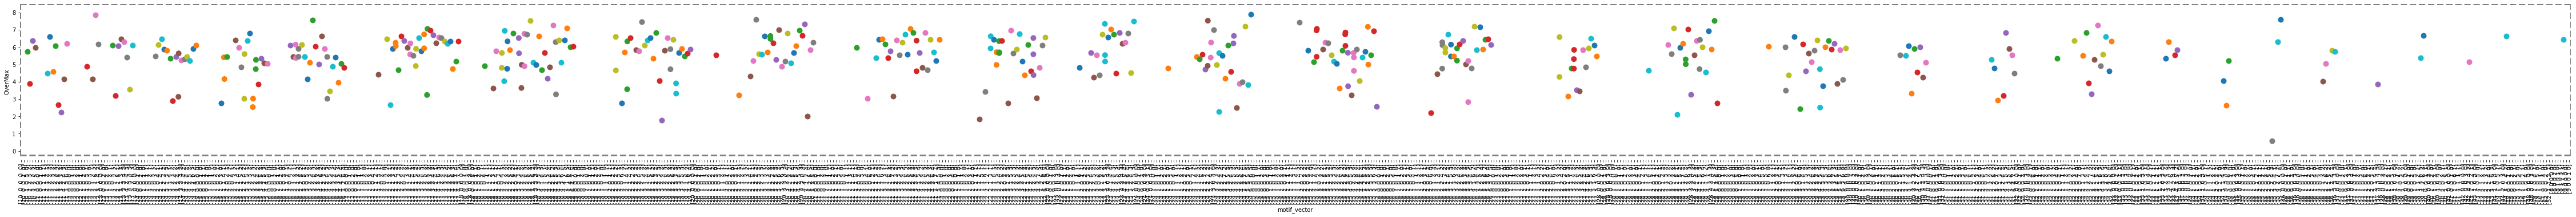

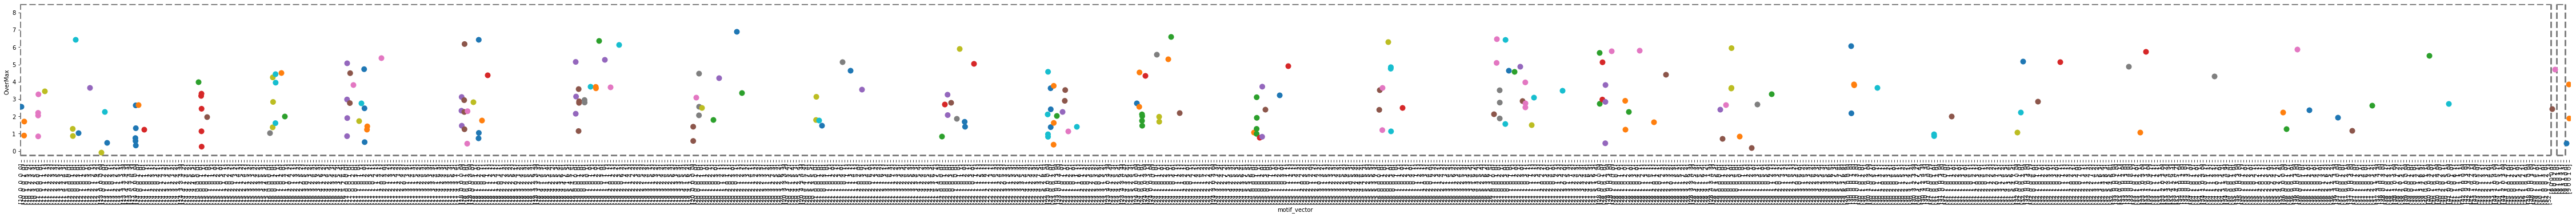

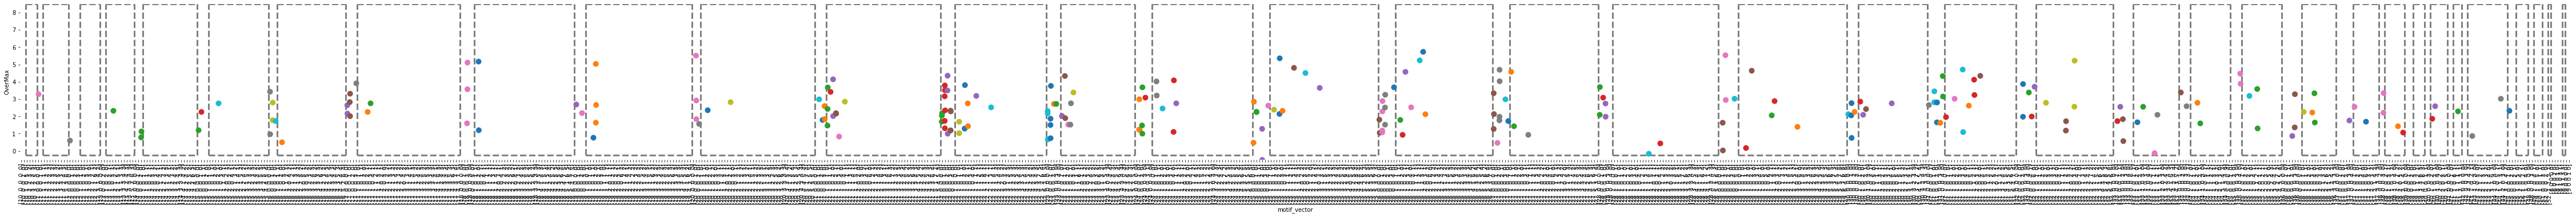

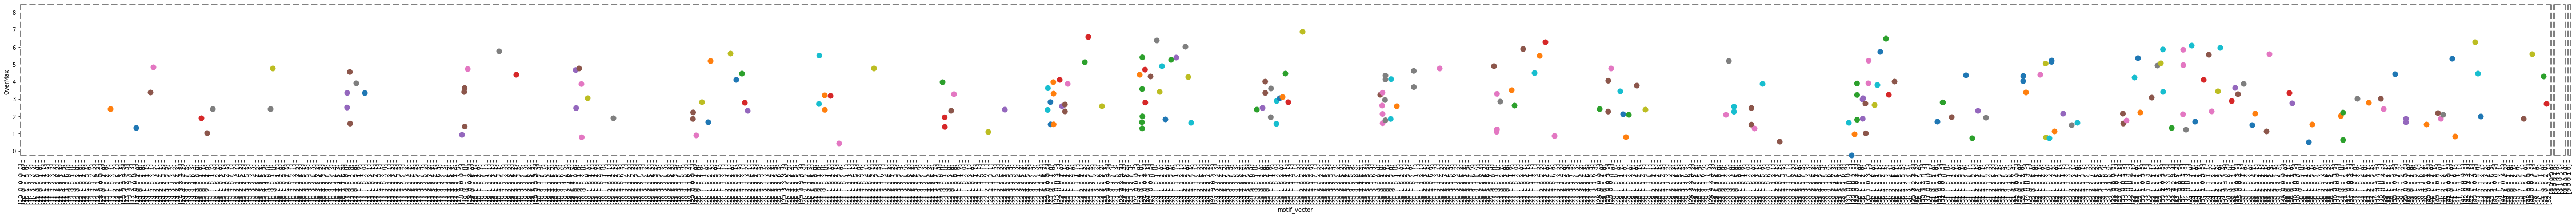

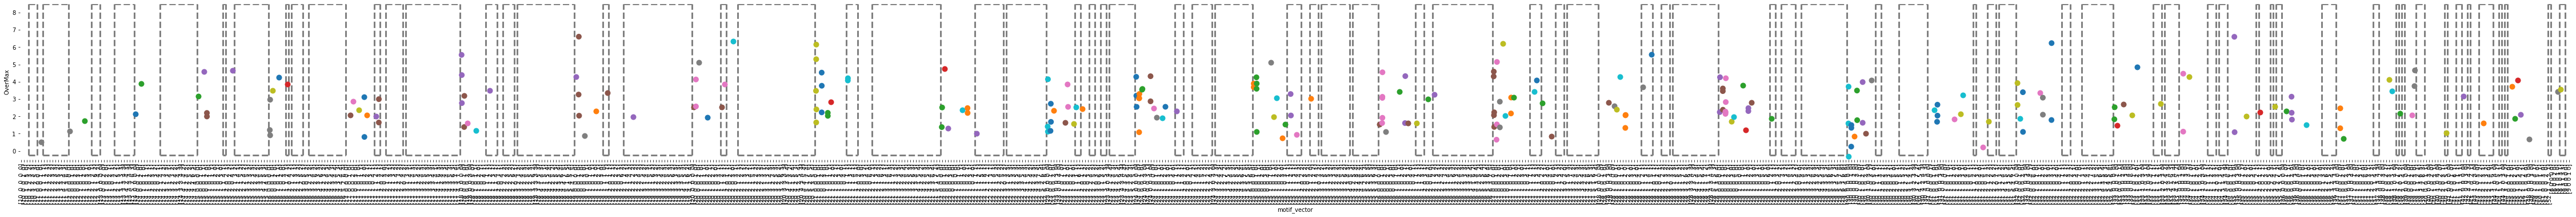

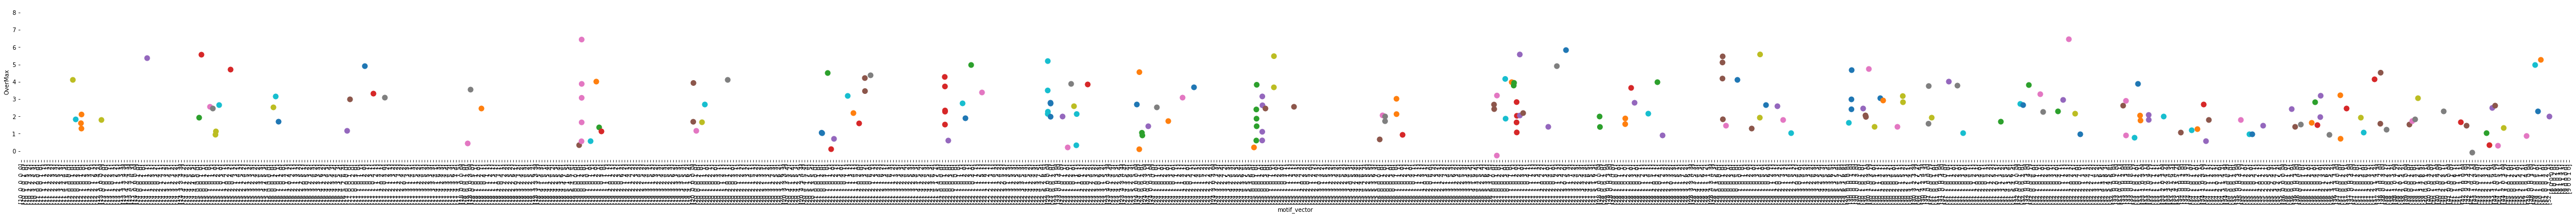

In [ ]:
for round_num in range(6):
    track_round_df = track_df[(track_df['round'] == round_num)].reset_index()
    
    y_min = -0.5
    y_max = 8.5
    plt.figure(figsize=(80,5))  
    if round_num < 5:
        box_idxs = all_motif_boxes[round_num]
        for box in box_idxs:
            box_start = box[0] - 0.5
            box_stop = box[-1] + 0.5
            box_low = y_min + 0.25
            box_top = y_max
            plt.vlines(box_start, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.vlines(box_stop, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_low, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_top, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)   
    sns.stripplot(data=track_round_df, x='motif_vector', y='OverMax', order=all_x_ticks, s=10, palette='tab10')    
    plt.box(False)
    plt.xticks(rotation=90)
    plt.ylim(y_min, y_max)  
    plt.show()

In [ ]:
binary_string_vectors = [str(1*(track_df[motif_columns] > 0).to_numpy()[row, :]) for row in range(len(track_df))]
track_df['binary_string_vector'] = binary_string_vectors
all_x_ticks = sorted(set(binary_string_vectors))

all_motif_boxes = []
for i in range(5):
    motif_boxes = [all_x_ticks.index(tick) for tick in all_x_ticks if tick.lstrip('[').rstrip(']').split(' ')[i] != '0']
    all_motif_boxes.append(consecutiveRanges(motif_boxes))

for round_num in range(6):
    track_round_df = track_df[(track_df['round'] == round_num)].reset_index()
    
    y_min = -0.5
    y_max = 8.5
    plt.figure(figsize=(25,2)) 
    if round_num > 0:
        box_idxs = all_motif_boxes[round_num - 1]
#         for box in box_idxs:
#             box_start = box[0] - 0.5
#             box_stop = box[-1] + 0.5
#             box_low = y_min + 0.25
#             box_top = y_max
#             plt.vlines(box_start, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
#             plt.vlines(box_stop, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
#             plt.hlines(box_low, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)
#             plt.hlines(box_top, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0) 
    if round_num < 5:
        box_idxs = all_motif_boxes[round_num]
        for box in box_idxs:
            box_start = box[0] - 0.5
            box_stop = box[-1] + 0.5
            box_low = y_min + 0.25
            box_top = y_max
            plt.vlines(box_start, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.vlines(box_stop, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_low, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_top, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0) 
            
    sns.stripplot(data=track_round_df, x='binary_string_vector', y='OverMax', order=all_x_ticks, s=5, palette='tab10')  
    #sns.swarmplot(data=track_round_df, x='binary_string_vector', y='OverMax', order=all_x_ticks, s=3, palette='tab10') 
    sns.despine(bottom=True)
    #plt.box(False)
    plt.xticks(rotation=90)
    plt.ylim(y_min, y_max)  
    plt.xlabel('')
    plt.show()

In [ ]:
zero_idxs = [0, 1, 2, 3, 4]

zero_columns = list(np.array(motif_columns)[zero_idxs])
condition = (track_df[zero_columns[0]] == 0)
for i in range(1, len(zero_columns)):
    condition = condition & (track_df[zero_columns[i]] == 0)
len(track_df[condition])

349

In [ ]:
temp_df = track_df.loc[condition].sort_values('OverMax', ascending=False).reset_index(drop=True)[:10]

contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']
sequence_column_name = 'sequence'

onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(temp_df[sequence_column_name].tolist() )])
contribution_tensorote = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in temp_df[contribution_column]])
    contribution_tensorote.append(flat_contributions * onehot_sequences)

contribution_tensorote = torch.stack(contribution_tensorote)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
no_gata_idxs = []
for idx, seq in enumerate(temp_df['sequence'].tolist()):
    if ('GATA' not in seq) and ('TATC' not in seq):
    #if ('AAA' not in seq) and ('TTT' not in seq):
        no_gata_idxs.append(idx)
print(len(no_gata_idxs))

print(list(np.array(temp_df['ID'].tolist())[no_gata_idxs]))

1
['20211212_82245__817810__634::fsp__sknsh__1']


20211212_82245__817810__385::fsp__sknsh__0 | [0.48, -0.26, 5.89] | OverMax: 5.4



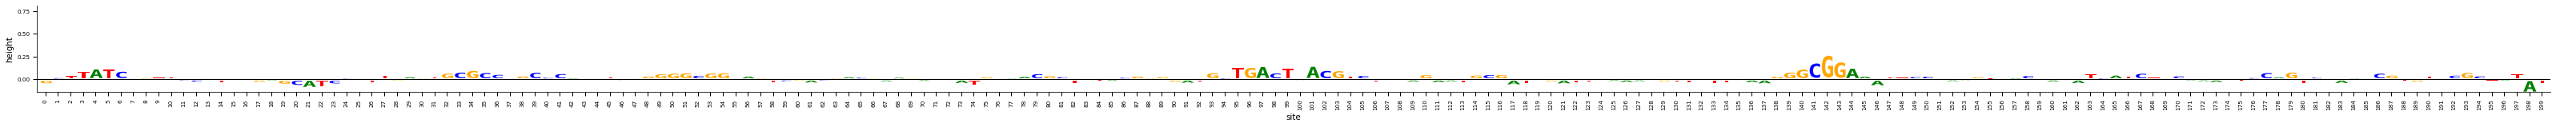

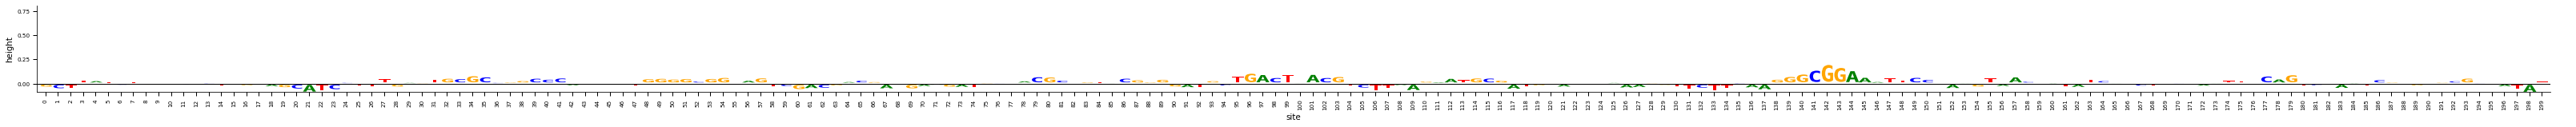

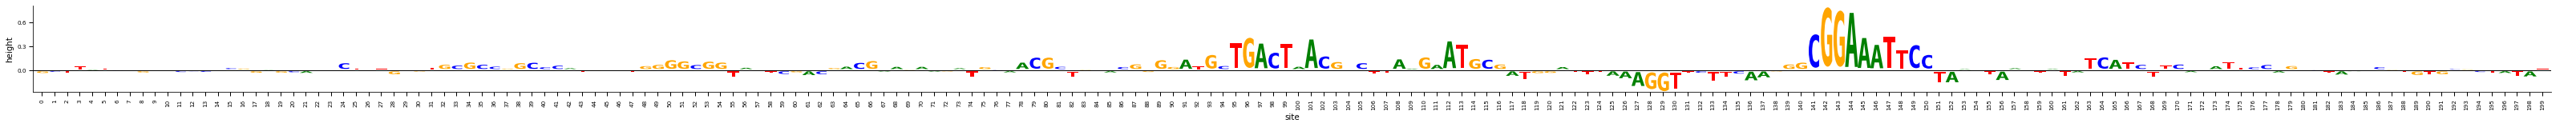


20211212_82245__817810__1498::fsp__sknsh__4 | [0.55, 0.24, 5.51] | OverMax: 4.96



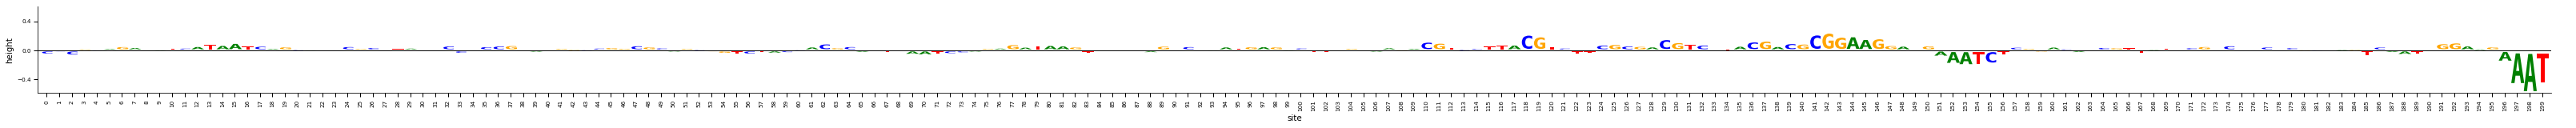

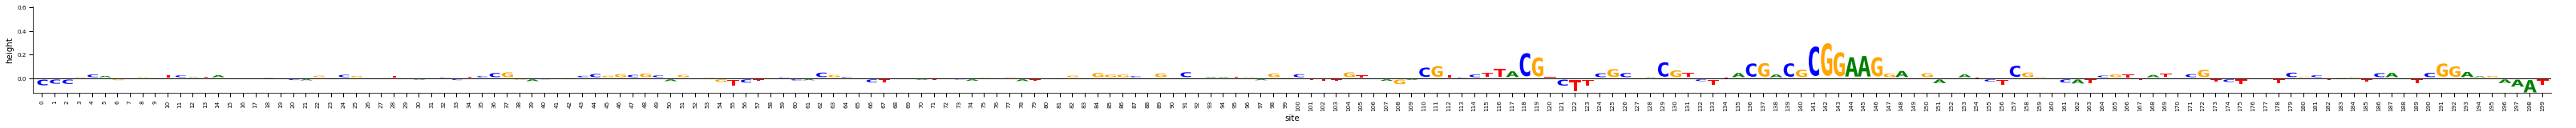

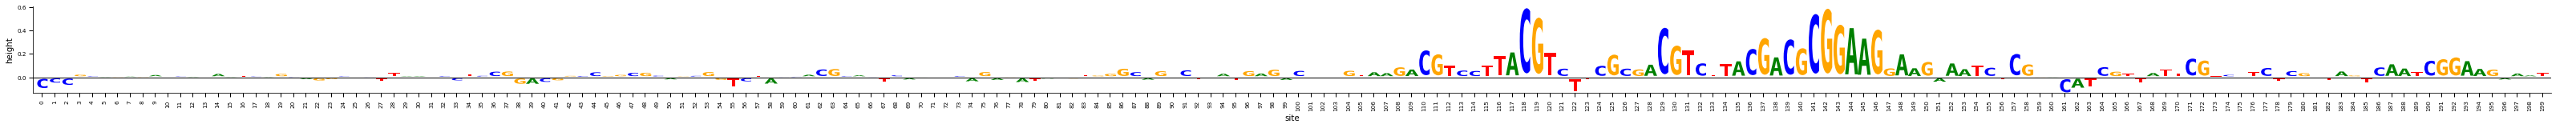


20211212_82245__817810__107::fsp__sknsh__0 | [-0.41, 0.72, 5.65] | OverMax: 4.93



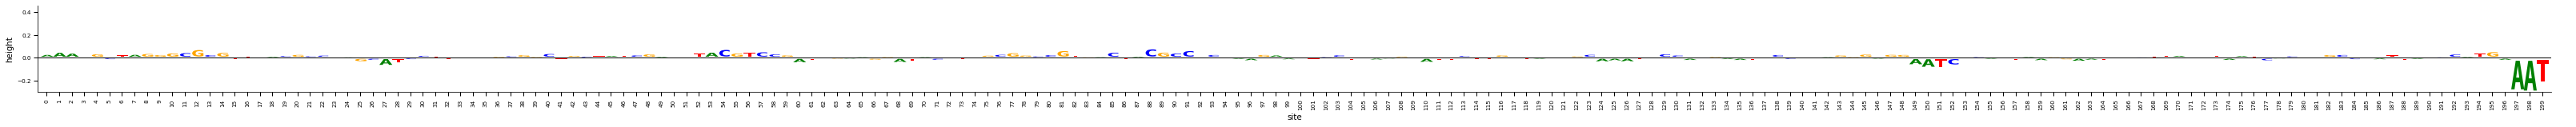

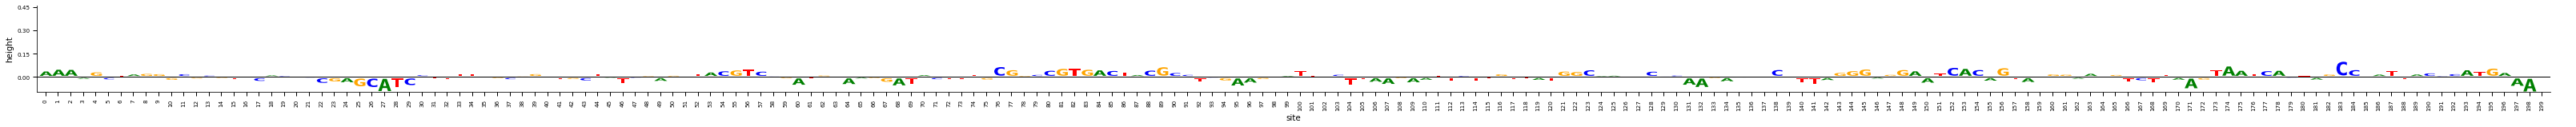

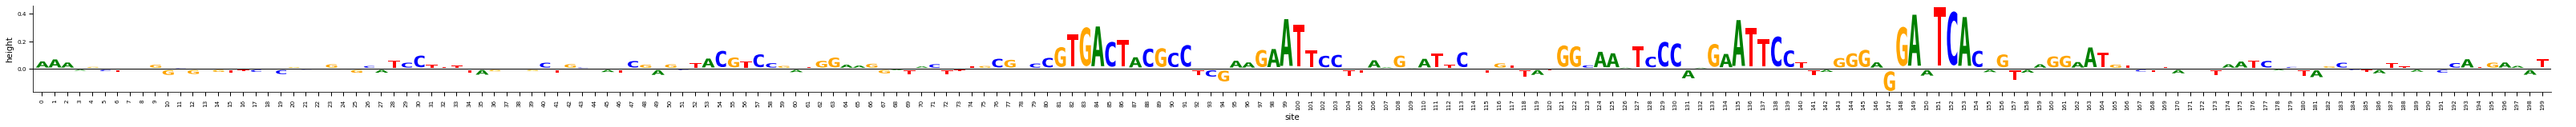


20211212_82245__817810__546::fsp__sknsh__1 | [-0.58, -0.14, 4.31] | OverMax: 4.44



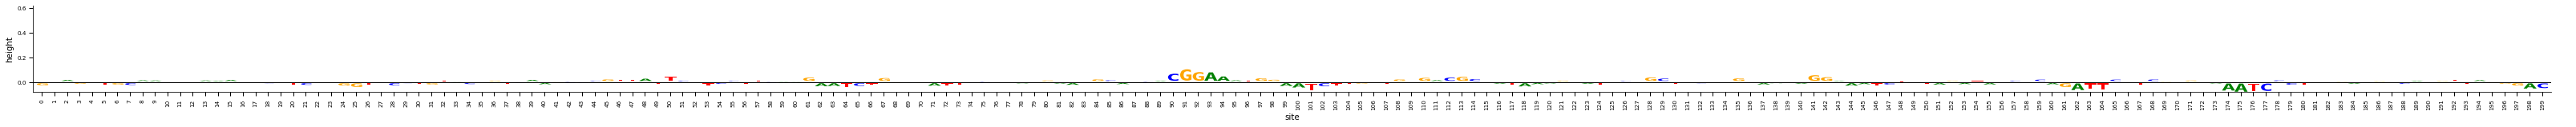

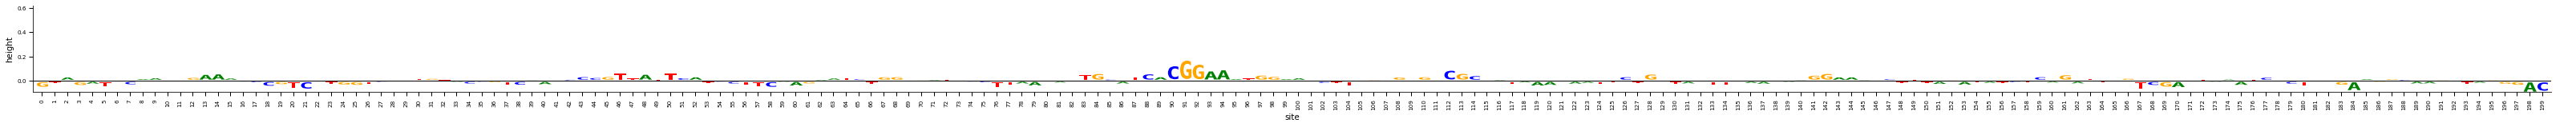

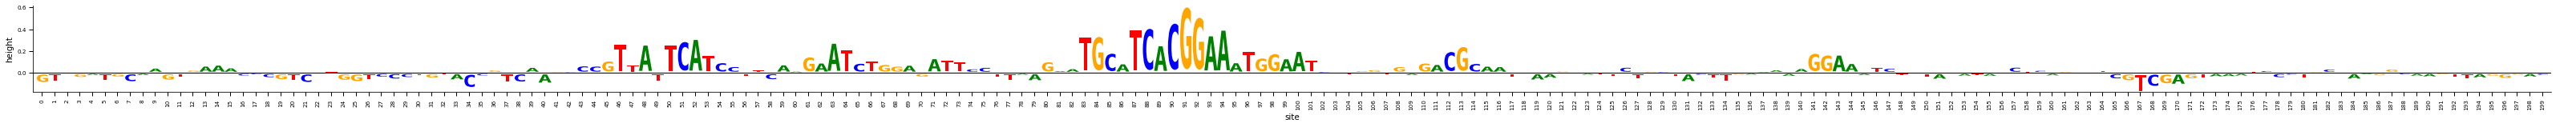


20211212_82245__817810__1597::fsp__sknsh__5 | [0.47, 0.54, 4.89] | OverMax: 4.34



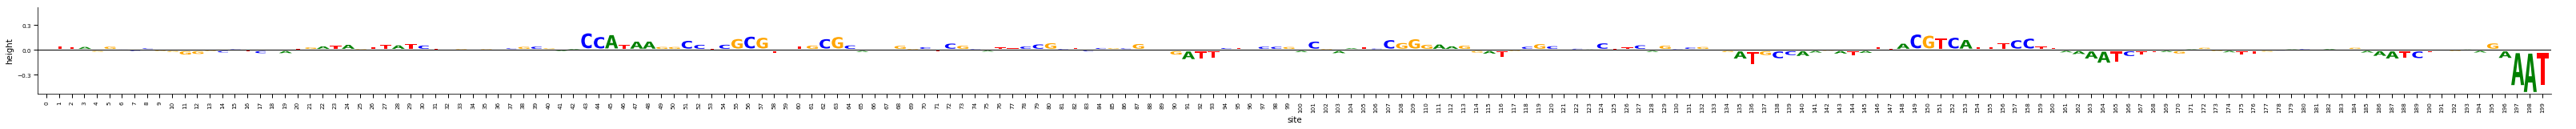

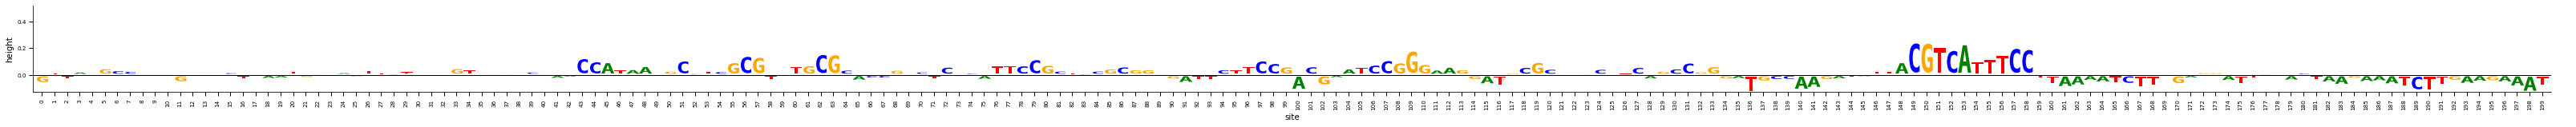

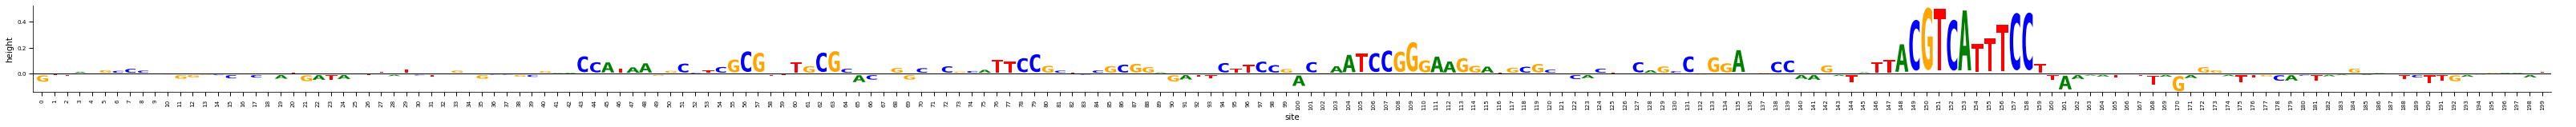


20211212_82245__817810__1254::fsp__sknsh__4 | [0.09, 1.02, 5.2] | OverMax: 4.18



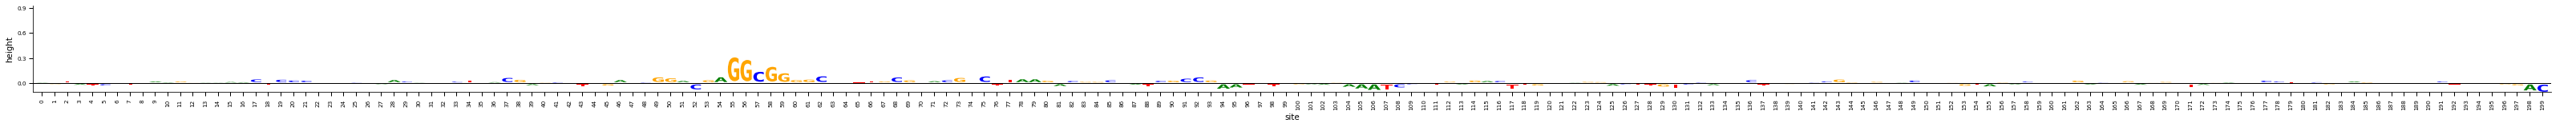

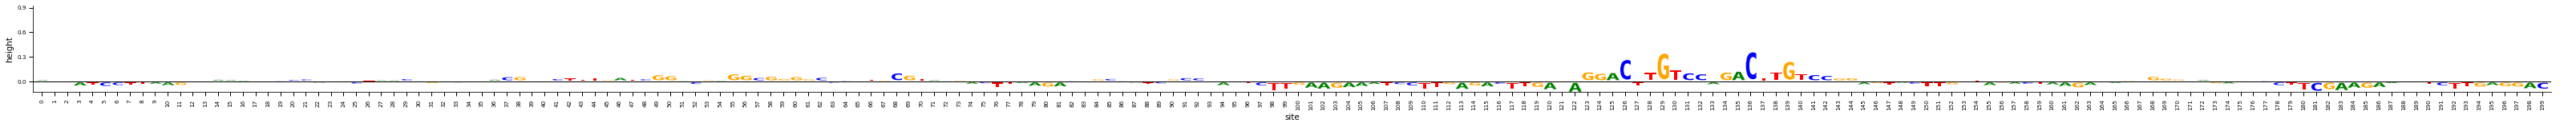

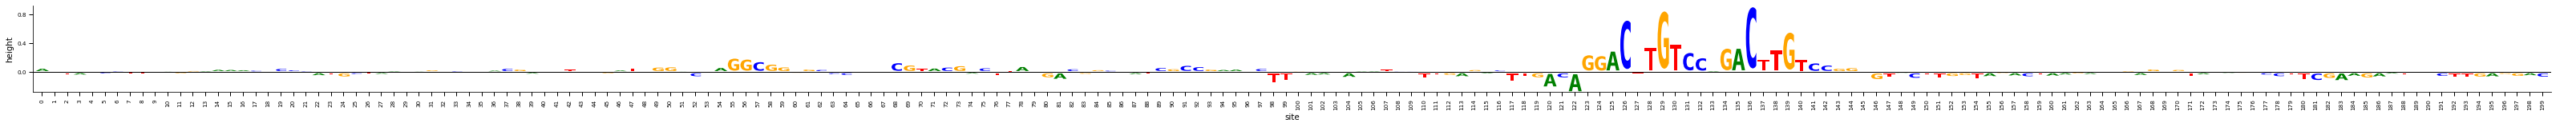


20211212_82245__817810__1551::fsp__sknsh__5 | [1.14, 0.4, 5.12] | OverMax: 3.98



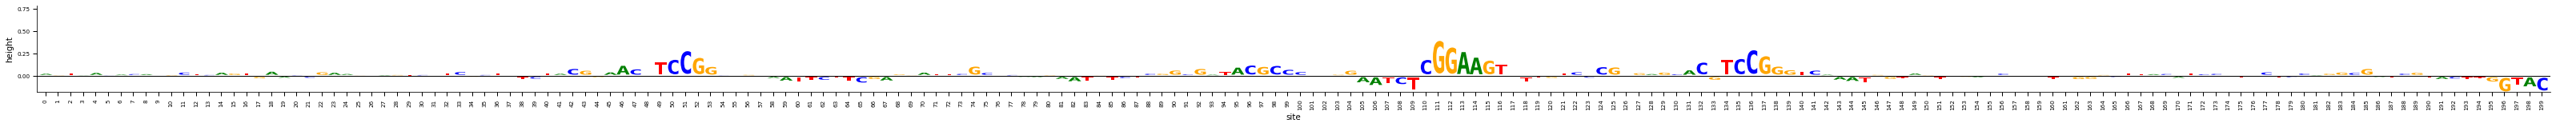

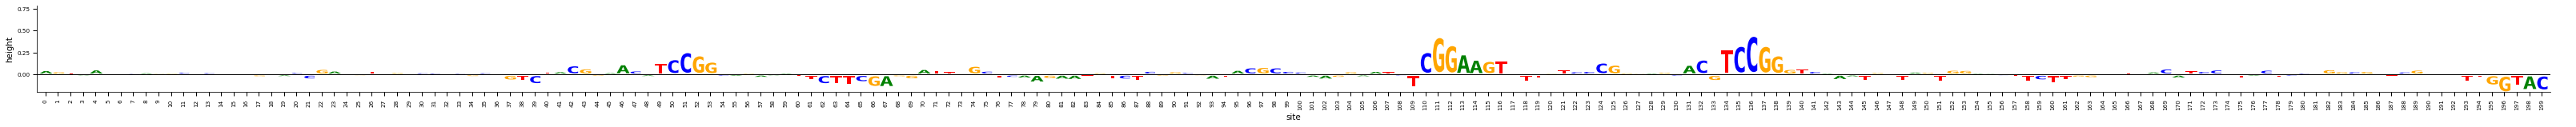

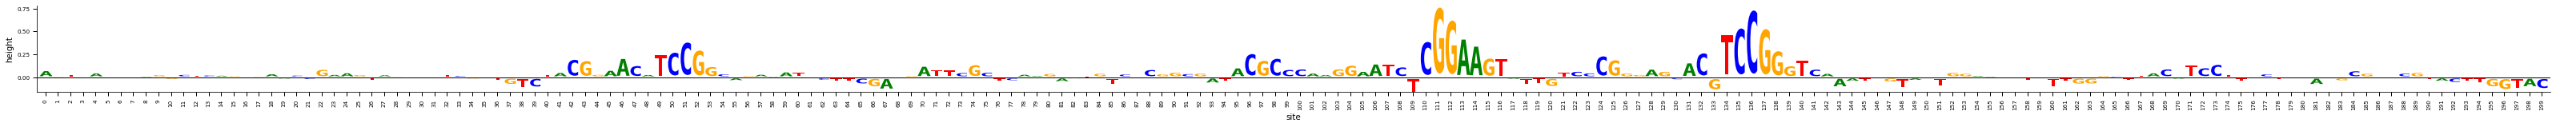


20211212_82245__817810__1607::fsp__sknsh__5 | [1.23, 1.71, 5.45] | OverMax: 3.73



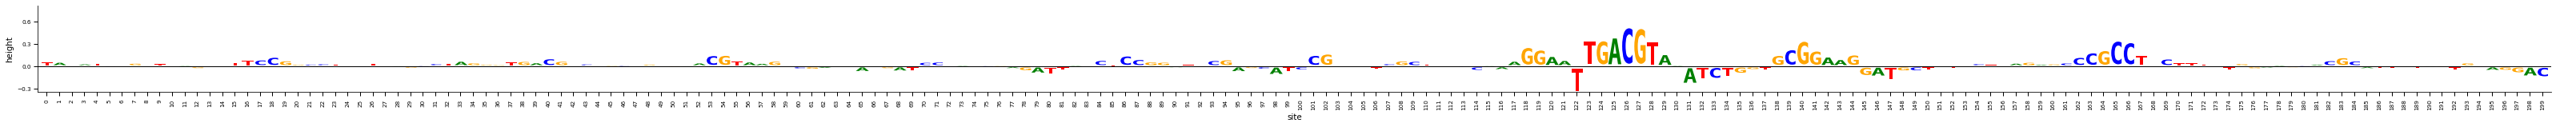

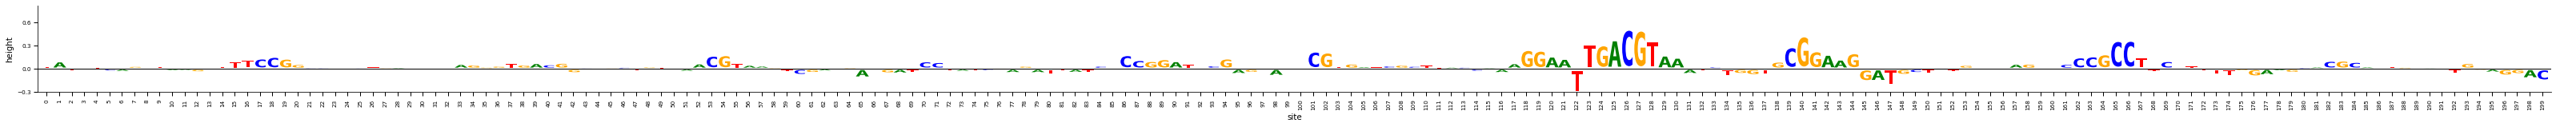

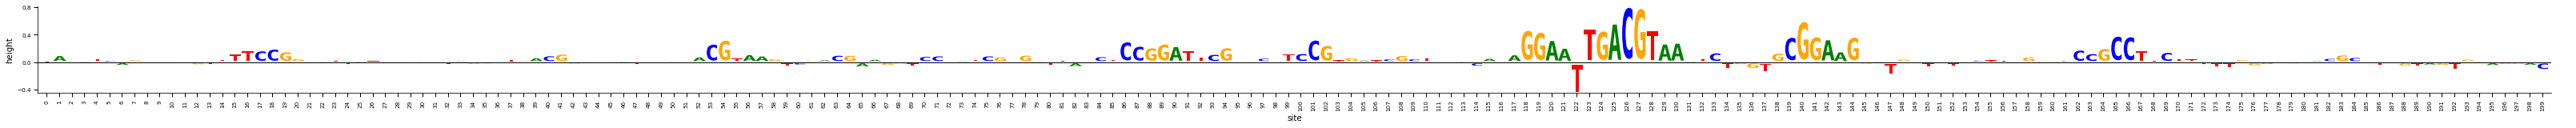


20211212_82245__817810__167::fsp__sknsh__0 | [-0.23, -0.03, 3.65] | OverMax: 3.69



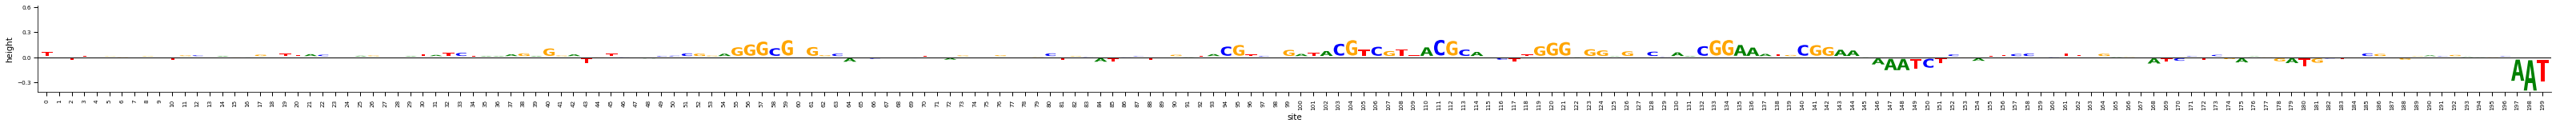

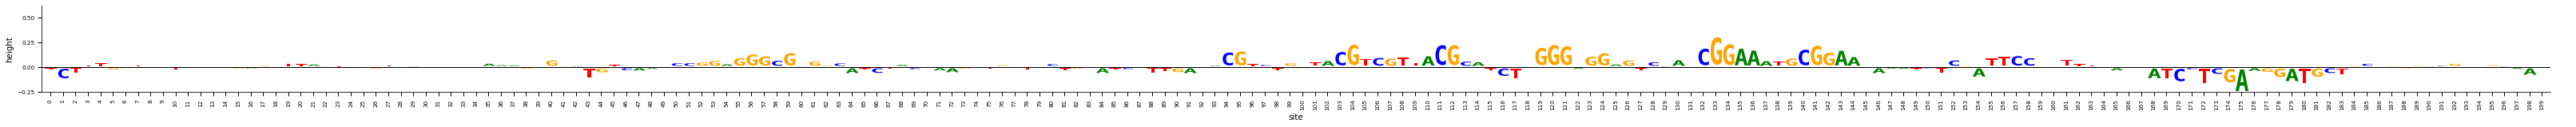

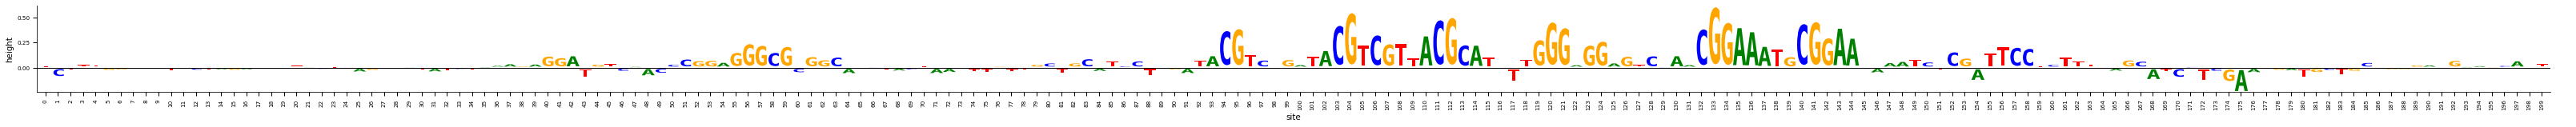


20211212_82245__817810__634::fsp__sknsh__1 | [-0.03, 2.02, 5.66] | OverMax: 3.64



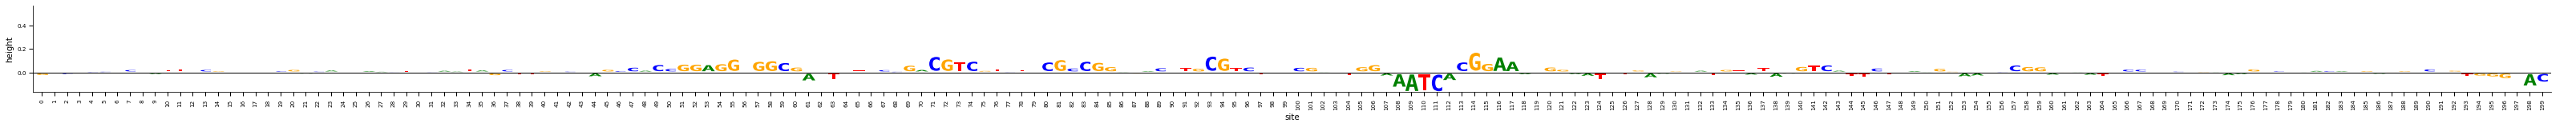

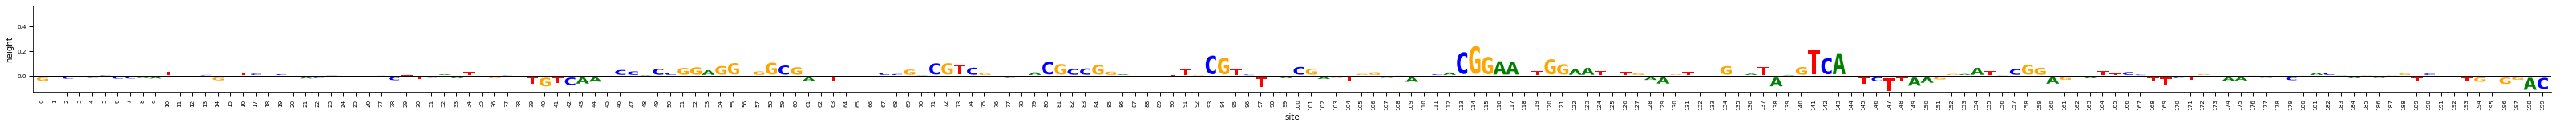

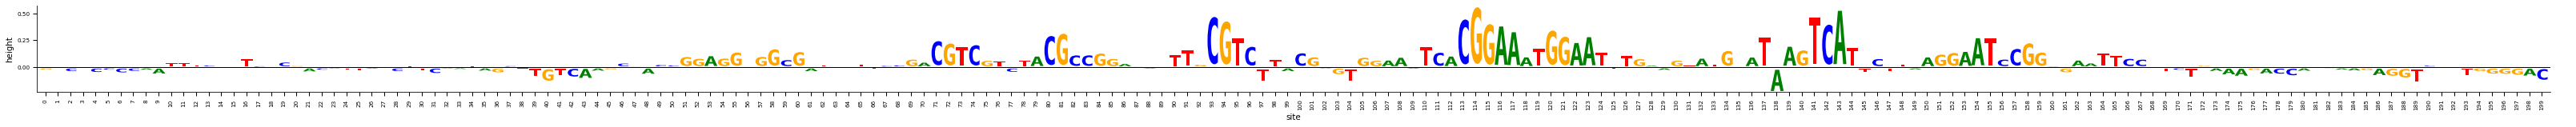

In [ ]:
for i in range(len(temp_df)):
    row_df = temp_df.iloc[i]
    seq_id = row_df['ID']
    seq_overmax = np.round(row_df['OverMax'], 2)
    signals = row_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal',]].tolist()
    signals = list(np.around(signals, decimals=2))
    print(f'{seq_id} | {signals} | OverMax: {seq_overmax}')
    print()
    plot_matrix = contribution_tensorote[:, i, ...]
    y_max = plot_matrix.max()
    for j in range(3):  
        matrix_to_dms(plot_matrix[j, ...], y_max=y_max)
        plt.show()
    print('')

In [ ]:
temp_df = no_controls_df[(no_controls_df['target_cell'] == 'k562') & (no_controls_df['OverMax'] >= 4.0) & (no_controls_df['method'] != 'train_set')].sort_values('OverMax', ascending=False).reset_index(drop=True)

temp_quality_filter = (temp_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
temp_df = temp_df[temp_quality_filter].copy().reset_index(drop=True)

no_gata_idxs = []
for idx, seq in enumerate(temp_df['sequence'].tolist()):
    if ('GATA' not in seq) and ('TATC' not in seq):
        no_gata_idxs.append(idx)
len(no_gata_idxs)

95

In [ ]:
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']
sequence_column_name = 'sequence'

onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(temp_df[sequence_column_name].tolist() )])
contribution_tensorote = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in temp_df[contribution_column]])
    contribution_tensorote.append(flat_contributions * onehot_sequences)

contribution_tensorote = torch.stack(contribution_tensorote)

  0%|          | 0/15014 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

chr13:78758700-78758900 | 6.96


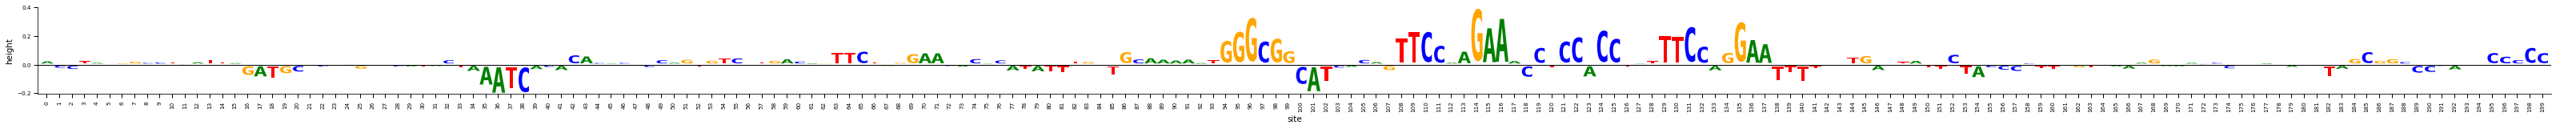

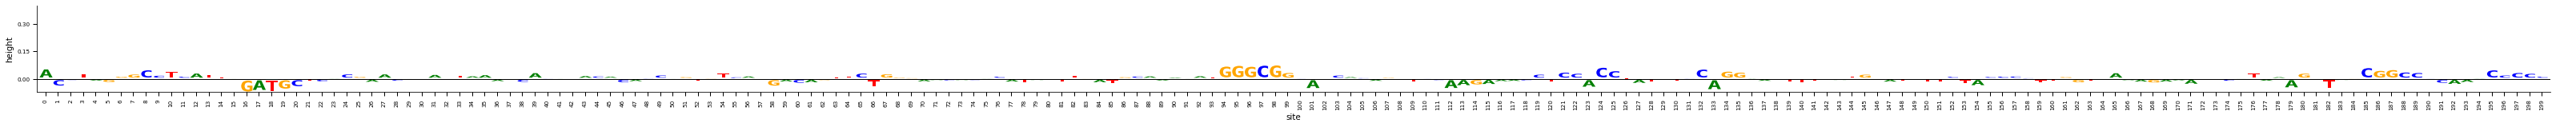

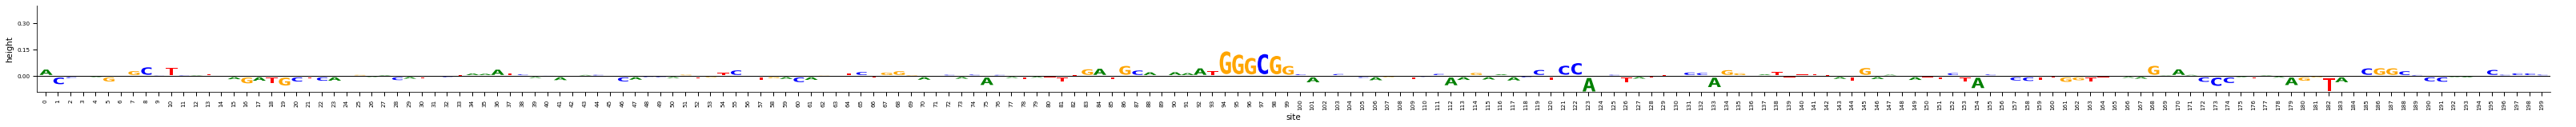


20211206_30151__45259191__1::al__k562__5 | 6.74


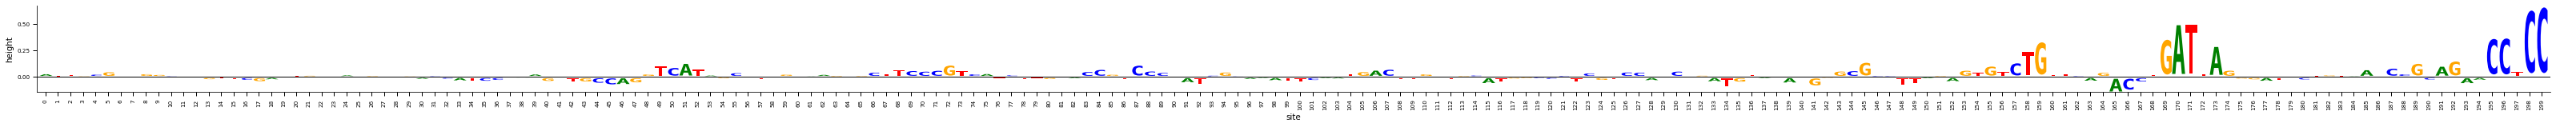

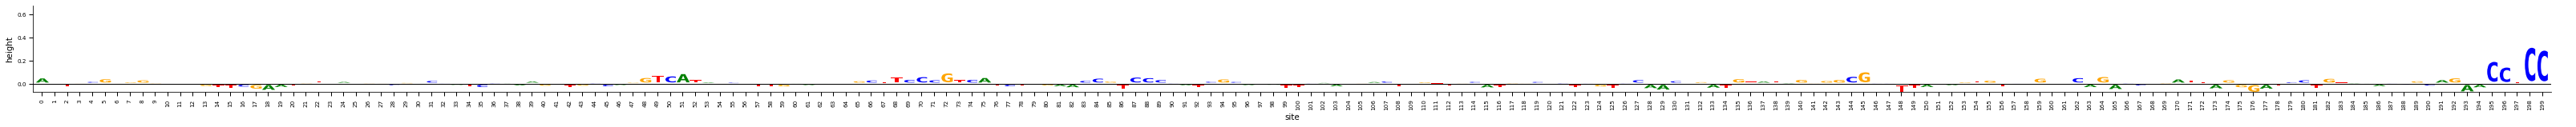

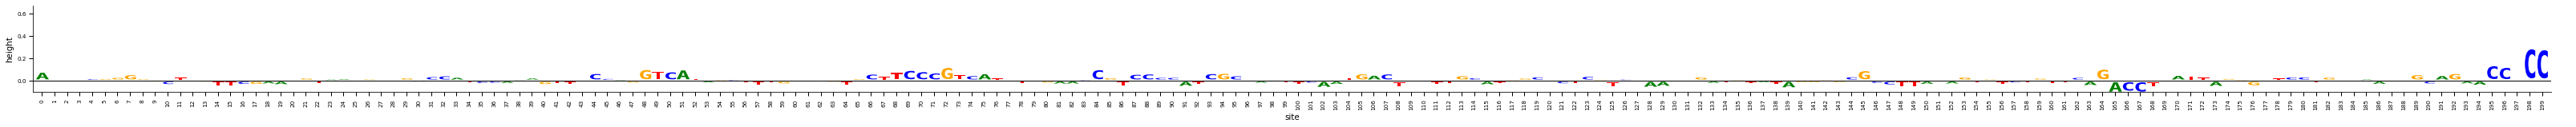


20211212_85225__619474__1680::fsp__k562__5 | 6.47


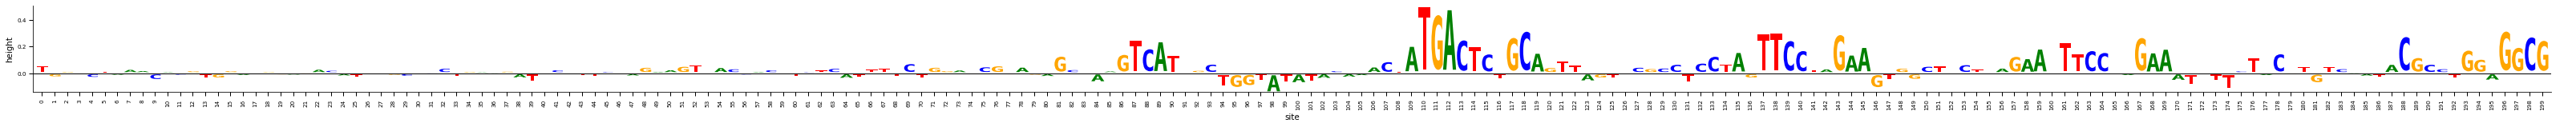

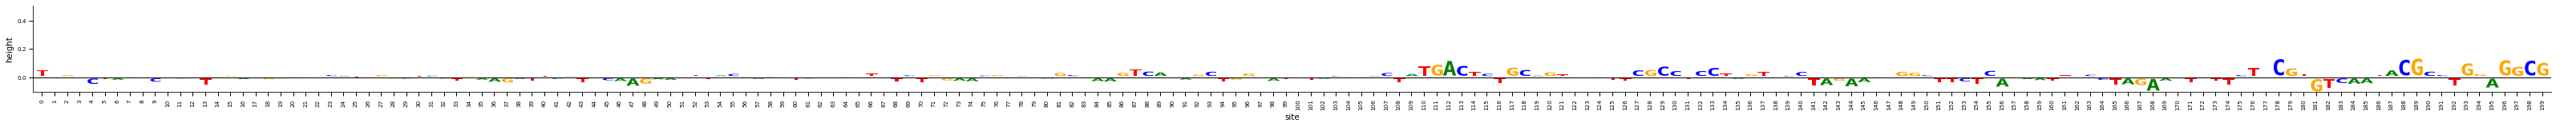

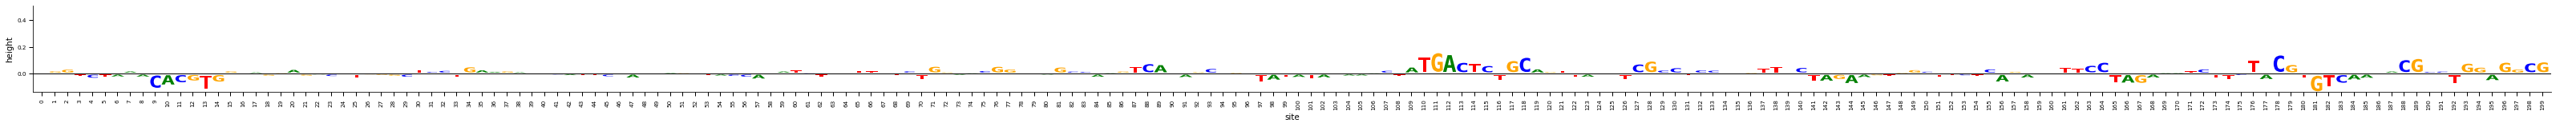


20211212_92818__893131__1633::fsp__k562__5 | 6.44


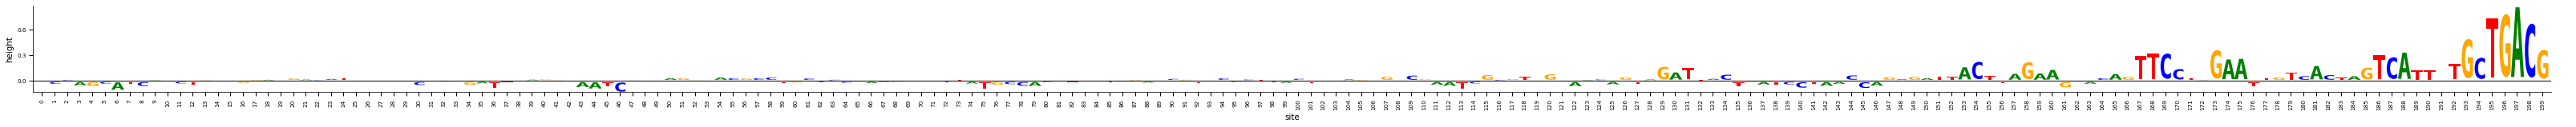

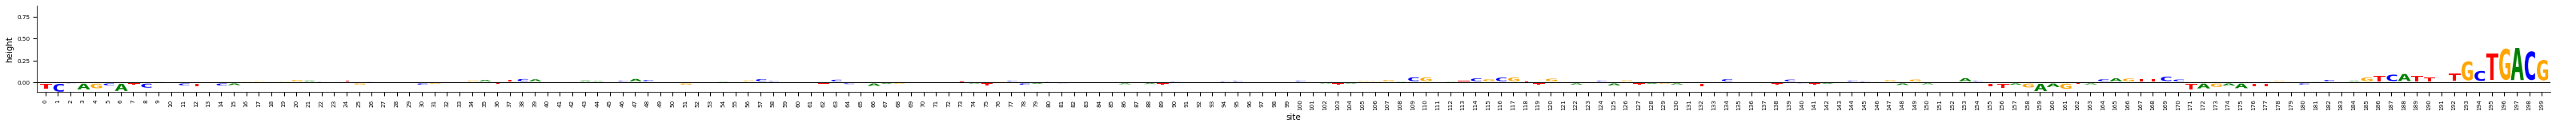

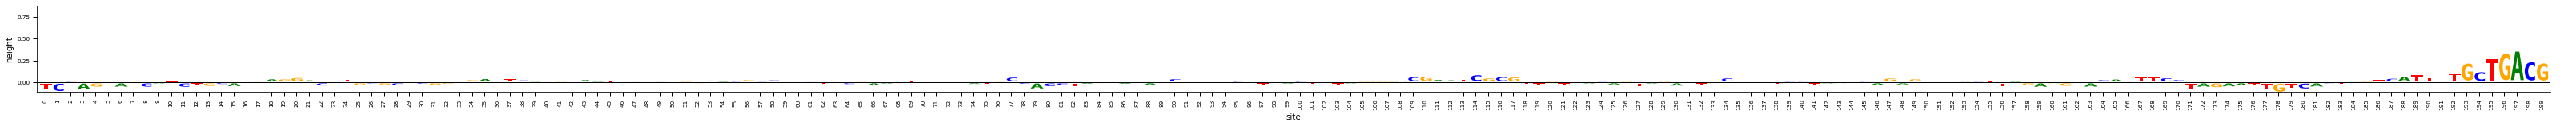


chr3:187745300-187745500 | 6.32


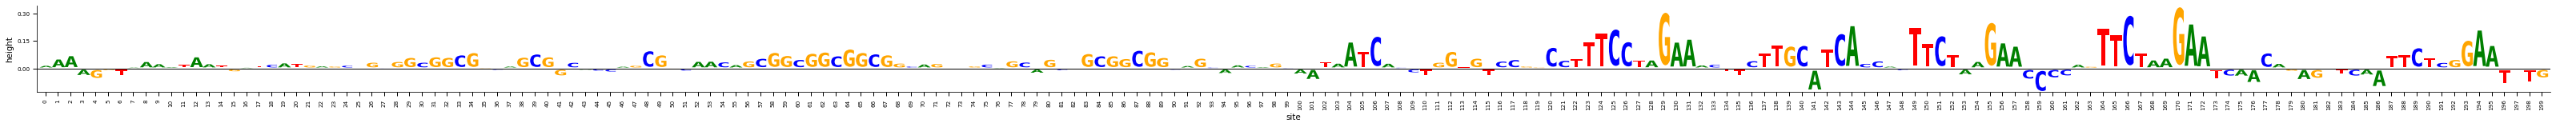

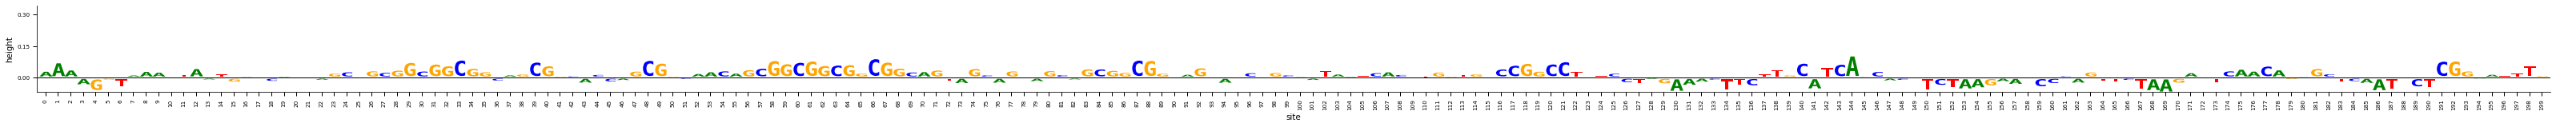

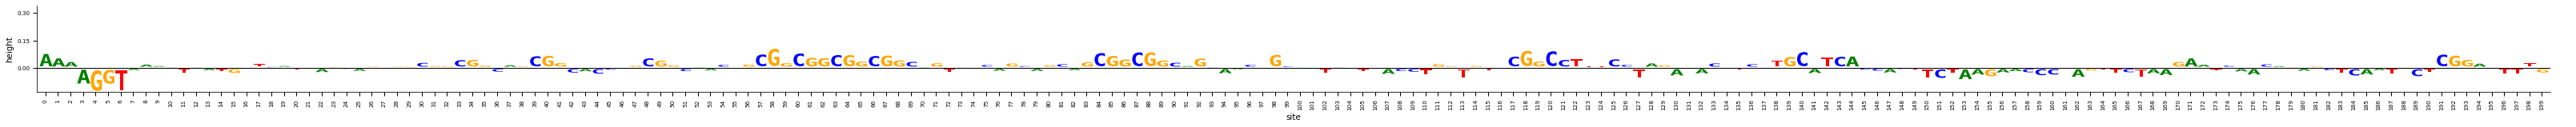


20211212_92818__893131__1479::fsp__k562__4 | 6.15


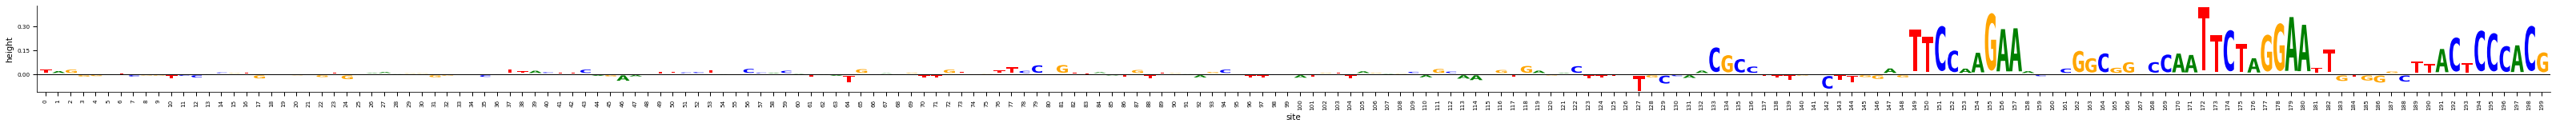

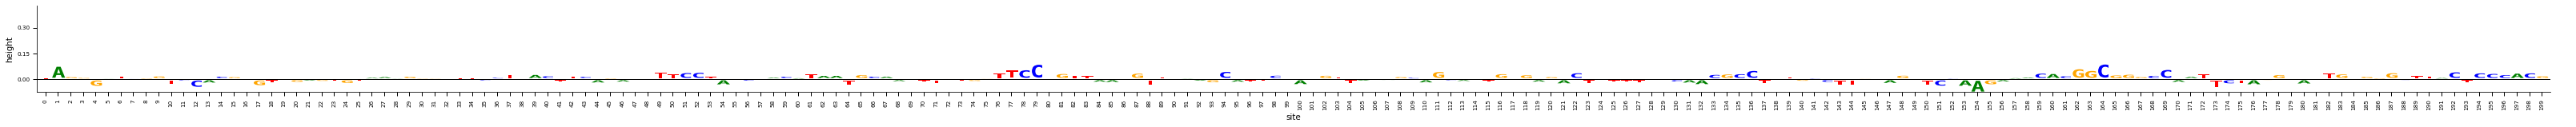

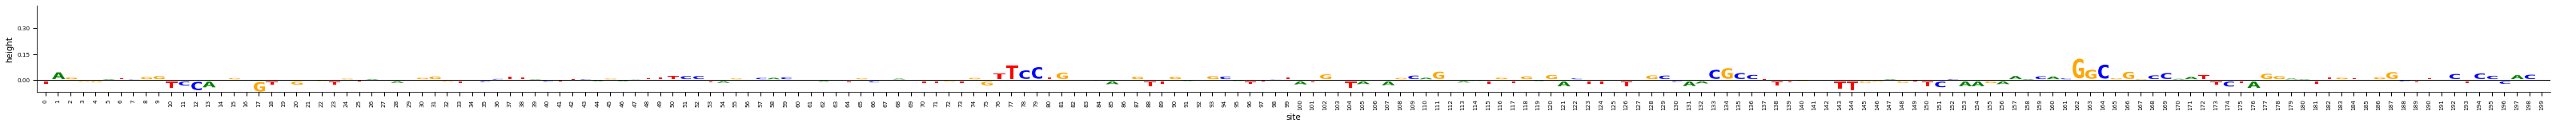


chr13:78758750-78758950 | 6.15


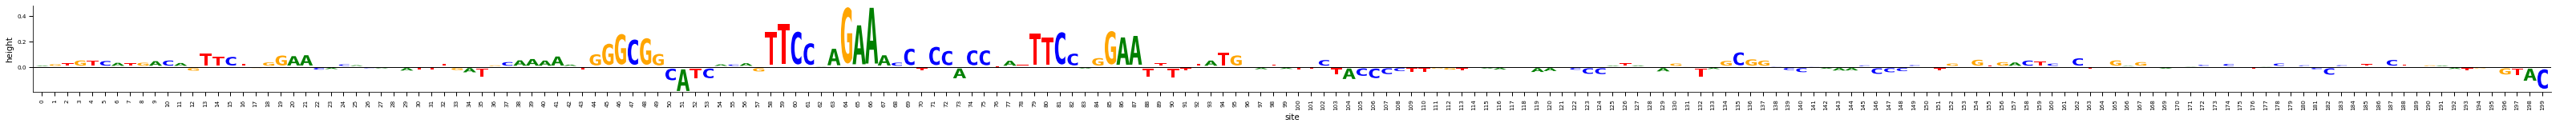

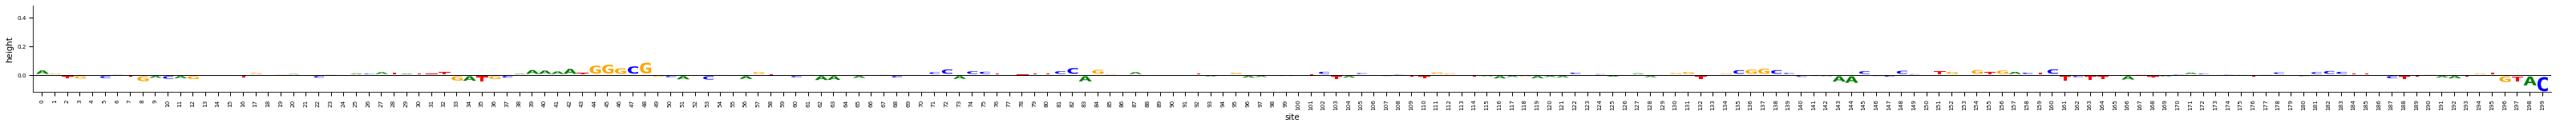

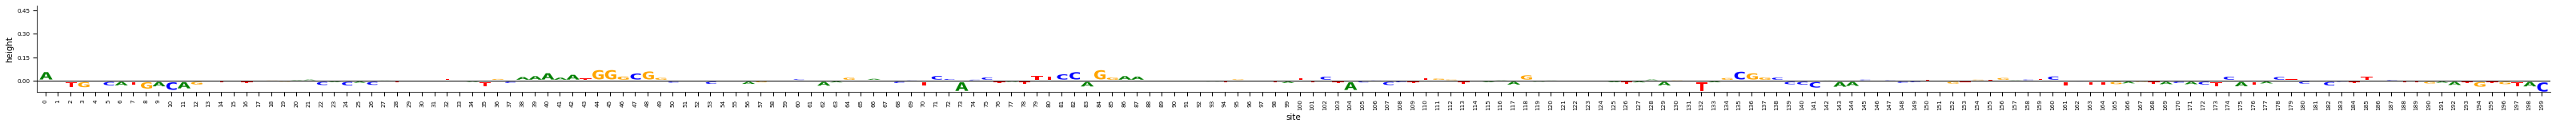


chr21:19119450-19119650 | 6.11


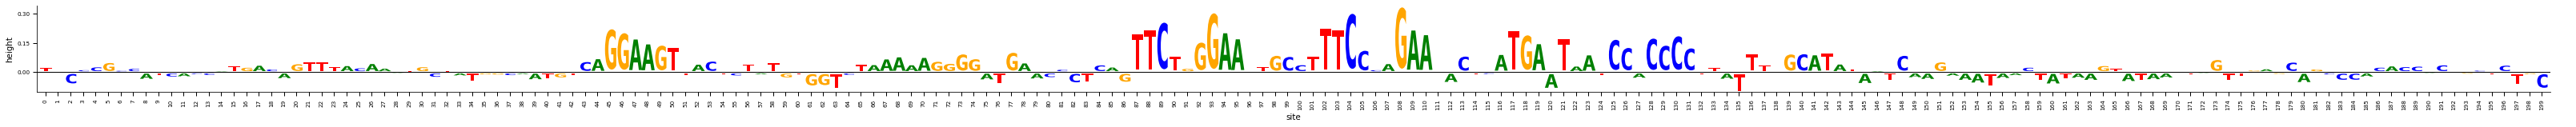

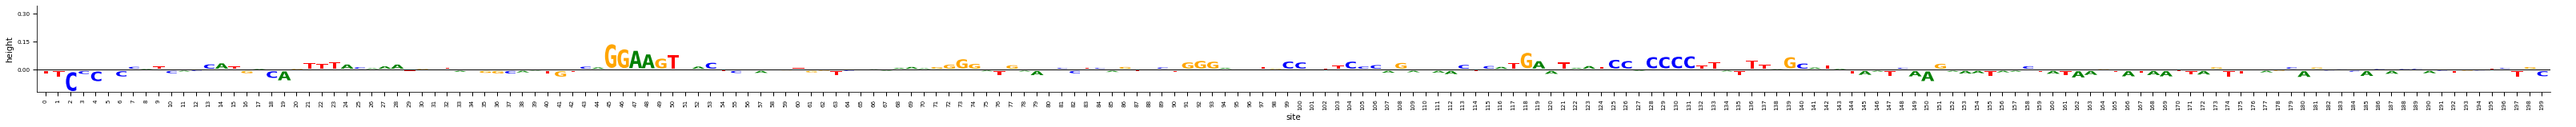

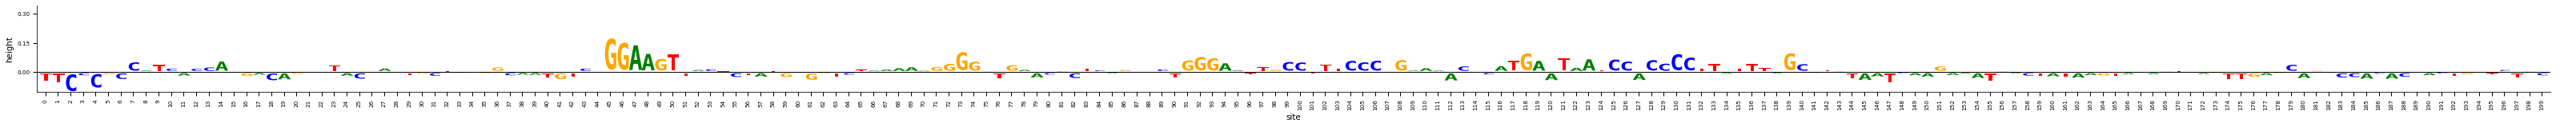


chr3:187745350-187745550 | 6.1


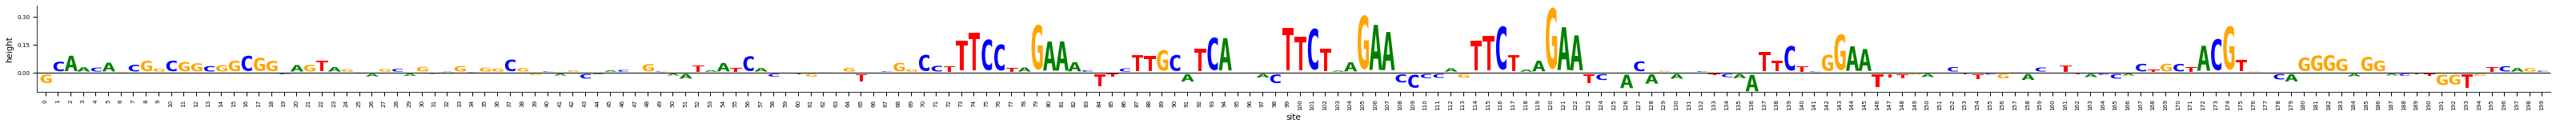

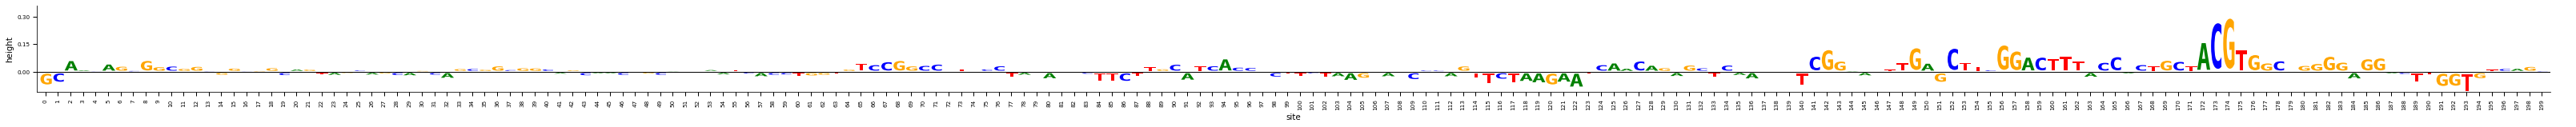

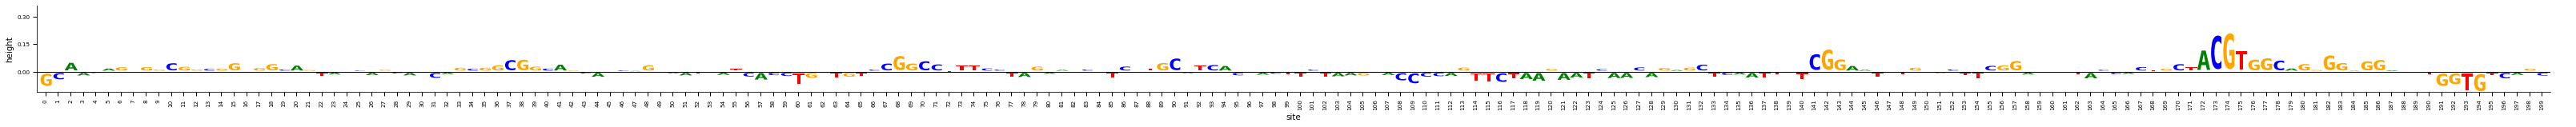


20211206_25934__90722511__91::al__k562__1 | 6.04


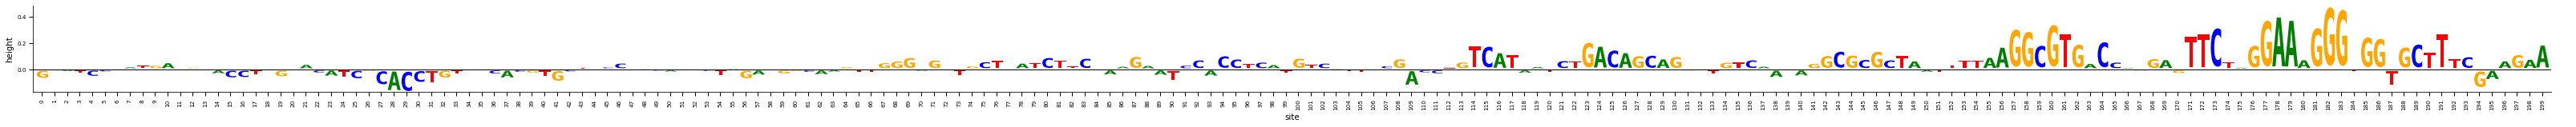

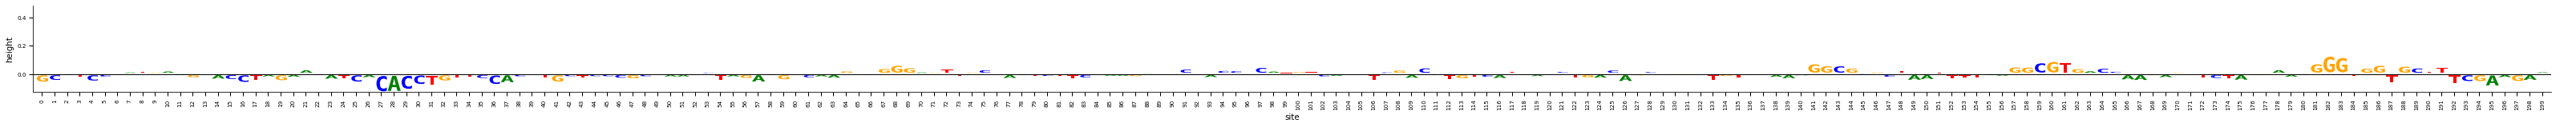

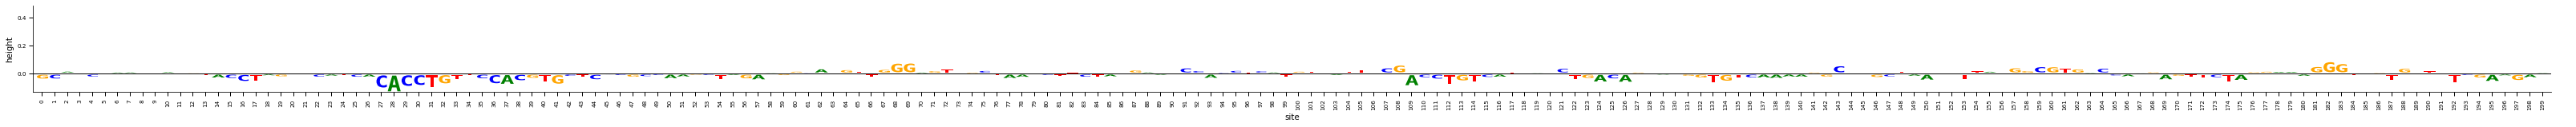

In [ ]:
for i in no_gata_idxs[:10]:
    row_df = temp_df.iloc[i]
    seq_id = row_df['ID']
    seq_overmax = np.round(row_df['OverMax'], 2)
    print(f'{seq_id} | {seq_overmax}')
    plot_matrix = contribution_tensorote[:, i, ...]
    y_max = plot_matrix.max()
    for j in range(3):  
        matrix_to_dms(plot_matrix[j, ...], y_max=y_max)
        plt.show()
    print('')